In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import fertilizantes_utils
sns.set_style('darkgrid')

### Precios Fertilizantes

In [2]:
precios_fertilizantes = pd.read_csv('data\precios_fertilizantes.csv', delimiter=';', encoding='latin1')

precios_fertilizantes['date'] = pd.to_datetime(precios_fertilizantes['date']) + pd.offsets.MonthEnd(0)
precios_fertilizantes.set_index('date', inplace=True)

In [3]:
# Obtener período de análisis:
años_precios_fertilizantes = precios_fertilizantes.index.year.unique()
primer_año_análisis = str(años_precios_fertilizantes.min())
último_año_análisis = str(años_precios_fertilizantes.max())

# Revisar período de análisis:
print('Primer año de análisis: ', primer_año_análisis)
print('Último año de análisis: ', último_año_análisis)

Primer año de análisis:  2013
Último año de análisis:  2023


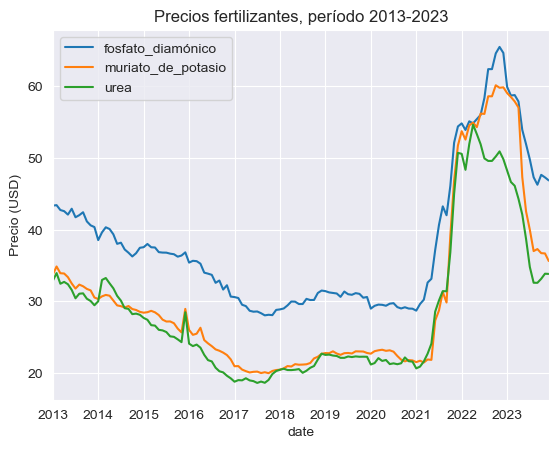

In [4]:
# Graficar precios de fertilizantes:
precios_fertilizantes.plot()
plt.title(f"Precios fertilizantes, período {primer_año_análisis}-{último_año_análisis}")
plt.ylabel("Precio (USD)")
plt.show()

### Gas natural y crudo Brent Europa

In [5]:
# Importar datos de precios de gas natural en Europa:
precio_commodities_Europa = pd.read_excel(
    'data\precios_commodities.xlsx',
    usecols=['date', 'gas_natural_europa_usd_mmbtu', 'precio_crudo_brent_usd_barril']
    )

precio_commodities_Europa['date'] = precio_commodities_Europa['date']\
    .str.replace('M', '-')\

precio_commodities_Europa['date'] = pd.to_datetime(
    precio_commodities_Europa['date']
    ) + pd.offsets.MonthEnd(0)

precio_commodities_Europa = precio_commodities_Europa\
    .set_index('date')\
    [primer_año_análisis:último_año_análisis]
    

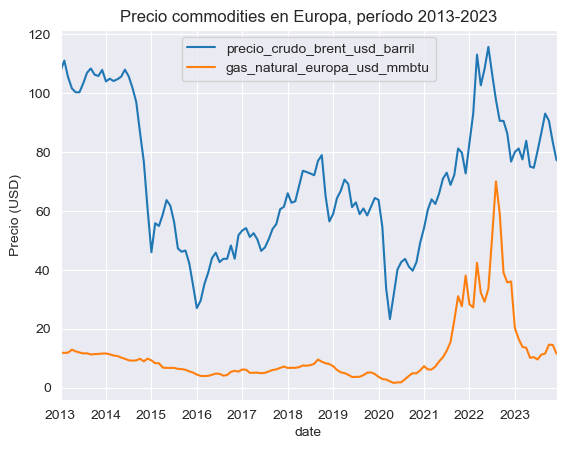

In [6]:
precio_commodities_Europa.plot()
plt.title(f"Precio commodities en Europa, período {primer_año_análisis}-{último_año_análisis}")
plt.ylabel("Precio (USD)")
plt.show()

In [7]:
np.corrcoef(precios_fertilizantes['urea'], precio_commodities_Europa['gas_natural_europa_usd_mmbtu'])[0,1]

0.8383487066026571

### Inflación

In [8]:
inflación_mensual = pd.read_csv('data\inflación_mensual_2.csv')

inflación_mensual['Inflación mensual general'] = inflación_mensual['Inflación mensual general'].str.replace(',', '.')

inflación_mensual_nacional = inflación_mensual\
    .rename(columns={
        'Mes': 'date',
        'Inflación mensual general': 'inflación_mensual'
        })\
    .astype({
        'date': 'datetime64[ns]',
        'inflación_mensual': 'float'
        })\
    [inflación_mensual['Región'] == 'NACIONAL']\
    .drop(columns=['Año', 'Región'])#

inflación_mensual_nacional['date'] = pd.to_datetime(inflación_mensual_nacional['date']) + pd.offsets.MonthEnd(0)

inflación_mensual_nacional = inflación_mensual_nacional\
    .set_index('date')\
    [primer_año_análisis:último_año_análisis]

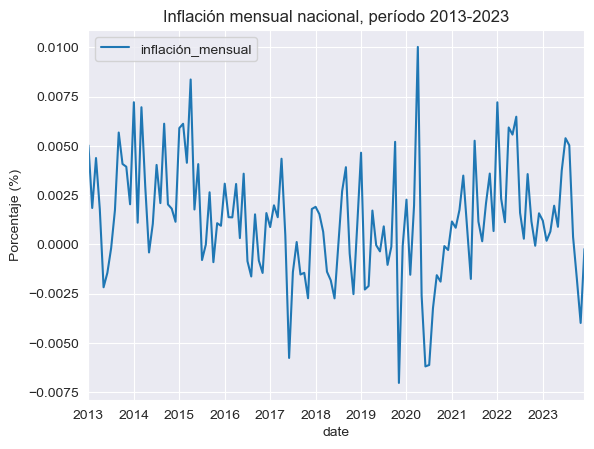

In [9]:
inflación_mensual_nacional.plot()
plt.title(f"Inflación mensual nacional, período {primer_año_análisis}-{último_año_análisis}")
plt.ylabel("Porcentaje (%)")
plt.show()

### Precios combustibles

In [10]:
precios_combustibles = pd.read_excel('data\precios-combustibles.xlsx')

precios_combustibles['date'] = pd.to_datetime(precios_combustibles['date']) + pd.offsets.MonthEnd(0)

precios_combustibles = precios_combustibles\
    .sort_values(by='date')\
#     .set_index('date')\
#     [primer_año_análisis:último_año_análisis]

In [11]:
# Encuentra la última fila y copia sus valores
precios_combustibles_dic_2023 = precios_combustibles.iloc[-1].copy().to_frame().T

# Cambia la fecha de '2023-11-30' a '2023-12-31'
precios_combustibles_dic_2023.loc[precios_combustibles_dic_2023['date'] == '2023-11-30', 'date'] = pd.Timestamp('2023-12-31')

In [12]:
# Obtener preciso inferidos basados en los primeros valores de cada columna original:
dict_precios_inferidos = {}

index_inferencias = pd.date_range(start='2013-01', end='2015-01', freq='M')

for col in precios_combustibles.columns:
    dict_precios_inferidos[col] = [precios_combustibles[col].iloc[0] for x in range(len(index_inferencias))]

# Cread DataFrame de precios de combustibles inferidos:
precios_combustibles_inferidos = pd.DataFrame(
    dict_precios_inferidos
    )

precios_combustibles_inferidos['date'] = index_inferencias

In [13]:
# Unir datos inferidos con los originales:
precios_combustibles_imp = pd.concat(
    [
        precios_combustibles_inferidos,
        precios_combustibles,
        precios_combustibles_dic_2023
    ],
    axis=0
    )\
    .reset_index()\
    .drop(columns=['index'])

precios_combustibles_imp['date'] = pd.date_range(start='2013-01', end='2024-01', freq='M')

precios_combustibles_imp.set_index('date', inplace=True)

for col in precios_combustibles_imp.columns:
    precios_combustibles_imp[col] = precios_combustibles_imp[col].astype('float')

In [14]:
precios_combustibles_imp.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 132 entries, 2013-01-31 to 2023-12-31
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   diesel                  132 non-null    float64
 1   gasolina_ecológica      132 non-null    float64
 2   gasolina_bajo_octanaje  132 non-null    float64
 3   gasolina_alto_octanaje  132 non-null    float64
dtypes: float64(4)
memory usage: 5.2 KB


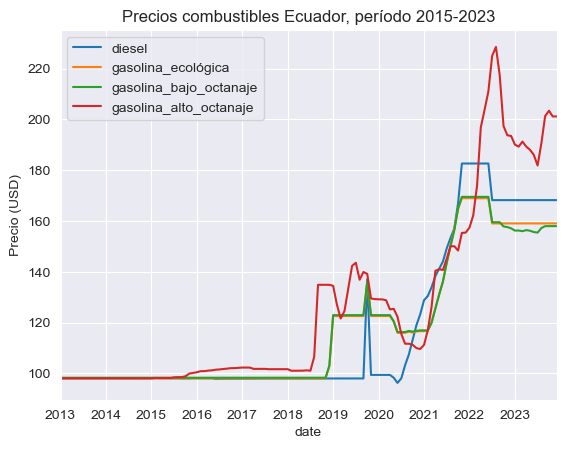

In [15]:
# Graficar precios de combustibles:
precios_combustibles_imp.plot()
plt.title(f"Precios combustibles Ecuador, período 2015-{último_año_análisis}")
plt.ylabel("Precio (USD)")
plt.show()

### Precios WTI

In [16]:
precios_wti = pd.read_excel('data\precios_wti.xlsx')

# Convertir las columnas a formato largo (melt)
precios_wti = precios_wti.melt(
    id_vars=["Year"],
    var_name="Month",value_name="precio_wti"
    )

# Crear la columna 'Fecha' a partir de 'Year' y 'Month'
precios_wti['date'] = pd.to_datetime(precios_wti['Year'].astype(str) + '-' + precios_wti['Month'].str[0:3] + '-01')

# Seleccionar solo las columnas 'Fecha' y 'Price':
precios_wti = precios_wti[['date', 'precio_wti']]

# Ordenar por 'date' y establecer como índice; filtrar por período de análisis:
precios_wti = precios_wti\
    .sort_values('date')\
    .reset_index(drop=True)\
    .set_index('date')\
    [primer_año_análisis:último_año_análisis]

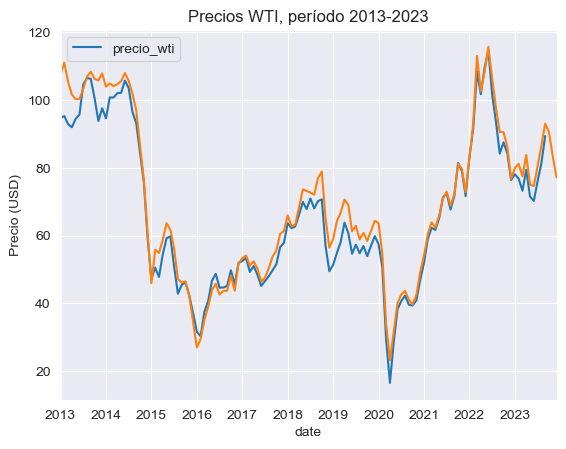

In [17]:
# Graficar:
precios_wti.plot()
precio_commodities_Europa['precio_crudo_brent_usd_barril'].plot()
plt.title(f"Precios WTI, período {primer_año_análisis}-{último_año_análisis}")
plt.ylabel("Precio (USD)")

plt.show()

### Datos energía eléctrica

In [18]:
# Importar datos de consumo eléctrico en diccionario, {año:DataFrame}
rango_años = np.arange(2013, 2024, 1)

dict_df_electricidad = {
    str(año): pd.read_excel(
        f'data/energía-eléctrica/rpConsolidadoFacCliRegxParr-{año}.xlsx',
        usecols=['año', 'mes', 'grupo_consumo',	'provincia', 'cantón', 'energía_facturada_kwh', 'facturación_electricidad_usd'],
        engine='openpyxl'
        ) for año in rango_años
    }

In [19]:
# Concatenar DataFrames verticalmente:
datos_electricidad = pd.concat(dict_df_electricidad.values(), axis=0, ignore_index=True)

mapeo_meses = {'Ene': '01', 'Feb': '02', 'Mar': '03', 'Abr': '04', 'May': '05', 'Jun': '06', 
               'Jul': '07', 'Ago': '08', 'Sep': '09', 'Oct': '10', 'Nov': '11', 'Dic': '12'}

datos_electricidad['date'] = pd.to_datetime(
    datos_electricidad['año'].astype(str) + \
        '-' + \
        datos_electricidad['mes'].map(mapeo_meses)
        ) + pd.offsets.MonthEnd(0)

datos_electricidad = datos_electricidad\
    .reset_index()\
    .sort_values(by='date')\
    .set_index('date')\
    .drop(columns=['index', 'año', 'mes'])\
    ['2014':'2023']
    

In [20]:
# Creación de variable de costo de electricidad (USD) por cada kwh: 

# Reemplazar ceros de las variables de origen por su mediana:
for var in ('energía_facturada_kwh', 'facturación_electricidad_usd'):    
    datos_electricidad[var].replace(0, datos_electricidad[var].mean(), inplace=True)

# Cálculo de la variable:
datos_electricidad['valor_usd_kwh'] = datos_electricidad['facturación_electricidad_usd'] / datos_electricidad['energía_facturada_kwh']


<Axes: xlabel='date'>

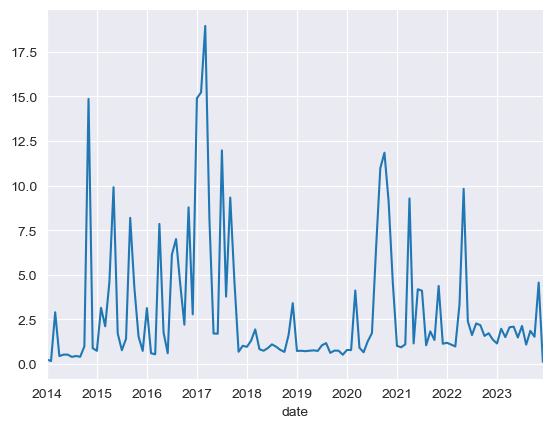

In [21]:
datos_electricidad.groupby(pd.Grouper(freq='M'))['valor_usd_kwh'].mean().plot()

In [22]:
datos_electricidad.groupby('grupo_consumo')['valor_usd_kwh'].mean()

grupo_consumo
Alumbrado Público    131.269578
Comercial              0.110993
Industrial             0.168777
Otros                  0.627826
Residencial            0.154735
Name: valor_usd_kwh, dtype: float64

In [23]:
# Filtramos el consumo eléctrico industrial:
datos_electricidad_industrial = datos_electricidad.query("grupo_consumo == 'Industrial'").copy()

In [24]:
# Calcula el Q1 y Q3
Q1 = datos_electricidad_industrial['valor_usd_kwh'].quantile(0.25)
Q3 = datos_electricidad_industrial['valor_usd_kwh'].quantile(0.75)

# Calcula el IQR
IQR = Q3 - Q1

# Define los límites para identificar valores atípicos
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filtrar valores atípicos
outliers = datos_electricidad_industrial[
    (datos_electricidad_industrial['valor_usd_kwh'] < lower_bound) | 
    (datos_electricidad_industrial['valor_usd_kwh'] > upper_bound)
]

# Mostrar valores atípicos
outliers.sort_values(by='valor_usd_kwh', ascending=False)

grupo_consumo   provincia                 cantón  \
date                                                          
2014-03-31    Industrial       AZUAY  CAMILO PONCE ENRÍQUEZ   
2016-12-31    Industrial      EL ORO                  PIÑAS   
2022-03-31    Industrial     BOLÍVAR              CHILLANES   
2015-05-31    Industrial   PICHINCHA                  MEJÍA   
2023-07-31    Industrial  TUNGURAHUA                 AMBATO   
...                  ...         ...                    ...   
2017-04-30    Industrial    LOS RÍOS            PUEBLOVIEJO   
2020-05-31    Industrial        LOJA               SARAGURO   
2015-03-31    Industrial       AZUAY  CAMILO PONCE ENRÍQUEZ   
2014-07-31    Industrial  ESMERALDAS            SAN LORENZO   
2022-03-31    Industrial      GUAYAS                SALITRE   

            energía_facturada_kwh  facturación_electricidad_usd  valor_usd_kwh  
date                                                                            
2014-03-31                    7.0                  32831.877718    4690.268245  
2016-12-31                    7.0                   1194.990000     170.712857  
2022-03-31                    2.0                    229.780000     114.890000  
2015-05-31                   -4.0                   -446.280000     111.570000  
2023-07-31                    2.0                    178.160000      89.080000  
...                           ...                           ...            ...  
2017-04-30                   31.0                  -1025.260000     -33.072903  
2020-05-31                  766.0                 -56593.040000     -73.881253  
2015-03-31                   -2.0                    173.460000     -86.730000  
2014-07-31                 -145.0                  32831.877718    -226.426743  
2022-03-31                    1.0                   -474.710000    -474.710000  

[12571 rows x 6 columns]

In [25]:
# Reemplazar valores atípicos con la mediana
datos_electricidad_industrial['valor_usd_kwh'] = np.where(
    (datos_electricidad_industrial['valor_usd_kwh'] < lower_bound) | 
    (datos_electricidad_industrial['valor_usd_kwh'] > upper_bound),
    datos_electricidad_industrial['valor_usd_kwh'].median(),
    datos_electricidad_industrial['valor_usd_kwh']
)

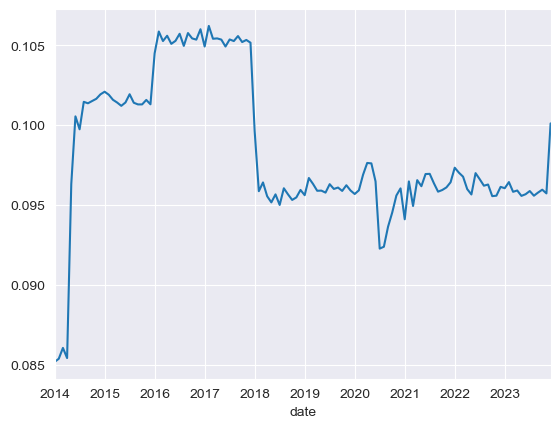

In [26]:
tarifa_eléctrica_industrial_media_mensual = datos_electricidad_industrial\
    .groupby(pd.Grouper(freq='M'))\
    ['valor_usd_kwh']\
    .mean()

tarifa_eléctrica_industrial_media_mensual.plot(kind='line')
plt.show()

### Datos climáticos

In [27]:
# URL del archivo JSON
url = "https://cckpapi.worldbank.org/cckp/v1/cru-x0.5_timeseries_pr,tas_timeseries_monthly_1901-2022_mean_historical_cru_ts4.07_mean/ECU?_format=json"

# Leer el archivo JSON desde la URL y cargarlo en un DataFrame de pandas
datos_climáticos_bm = pd.read_json(url)\
    .drop(columns=['metadata'])\
    .dropna()


# Inicializa el diccionario de salida:
dict_datos_climáticos = {}

# Itera sobre el índice del DataFrame:
for i in datos_climáticos_bm.index:
    # Extrae los valores directamente y aplana la lista anidada
    flattened_values = [v for sublist in datos_climáticos_bm.loc[i].values[0].values() for v in sublist.values()]
    # Asigna los valores al diccionario:
    dict_datos_climáticos[i] = flattened_values

# Crear una serie de fechas entre fecha_inicial y fecha_final:
serie_fechas = pd.date_range(start='1901-01', end='2023-01', freq='M')

datos_climáticos = pd.DataFrame(
    dict_datos_climáticos,
    index=serie_fechas
    )\
    .rename(columns={'pr': 'precipitación_media_mm', 'tas':'temp_media_Celsius'})\
    [primer_año_análisis:último_año_análisis]

#### Imputación provisional de datos climáticos para 2023

In [28]:
datos_climáticos['Mes'] = datos_climáticos.index.month

rango_meses_2023 = pd.date_range(start='2023-01', end='2024-01', freq='M')

medias_mensuales_clima = datos_climáticos\
    .groupby('Mes')\
    [['precipitación_media_mm', 'temp_media_Celsius']]\
    .mean()\
    .reset_index()\
    .drop(columns = ['Mes'])\
    .set_index(rango_meses_2023)

medias_mensuales_clima

precipitación_media_mm  temp_media_Celsius
2023-01-31                 177.308              22.051
2023-02-28                 202.172              21.917
2023-03-31                 277.426              21.865
2023-04-30                 248.880              21.835
2023-05-31                 259.888              21.948
2023-06-30                 204.615              21.206
2023-07-31                 159.342              21.009
2023-08-31                  87.512              21.107
2023-09-30                 118.649              21.440
2023-10-31                 150.975              21.742
2023-11-30                 130.995              21.753
2023-12-31                 120.856              21.871

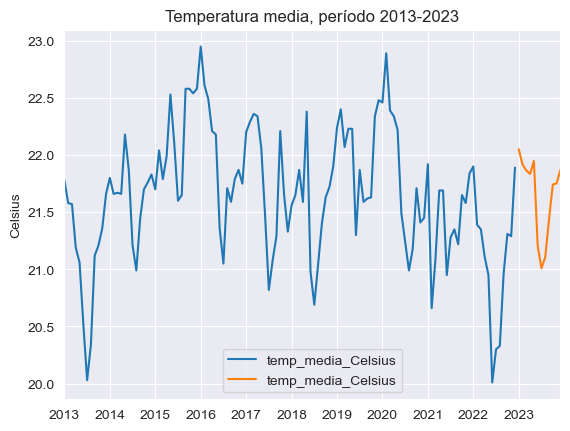

In [29]:
# Graficar temperatura media:
datos_climáticos['temp_media_Celsius'].plot()
medias_mensuales_clima['temp_media_Celsius'].plot()
plt.title(f"Temperatura media, período {primer_año_análisis}-{último_año_análisis}")
plt.ylabel("Celsius")
plt.legend()

plt.show()

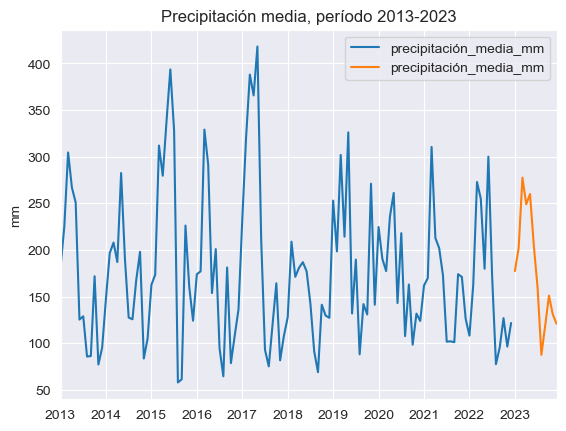

In [30]:
# Graficar precipitaciones:
datos_climáticos['precipitación_media_mm'].plot()
medias_mensuales_clima['precipitación_media_mm'].plot()
plt.title(f"Precipitación media, período {primer_año_análisis}-{último_año_análisis}")
plt.ylabel("mm")
plt.legend()

plt.show()
plt.show()

In [31]:
datos_climáticos_bm_imp = pd.concat([datos_climáticos, medias_mensuales_clima], axis=0)\
    .drop(columns=['Mes'])

#### Datos SIPA

In [32]:
# Datos de temperatura y precipitaciones SIPA:
datos_climáticos_sipa = pd.read_excel(r'data\temperatura-precipitacion-sipa.xlsx', sheet_name='temperatura_precipitación')

In [33]:
# Agregar datos para obtener valores medios nacionales:
datos_climáticos_sipa = datos_climáticos_sipa\
    .rename(columns={'Precipitación (mm)': 'precipitación_media_mm', 'Temperatura promedio (°C)':'temp_media_Celsius'})\
    .groupby(['Año', 'Mes'])\
    [['precipitación_media_mm', 'temp_media_Celsius']]\
    .mean()\
    .reset_index()

In [34]:
# Diccionario para mapear meses por sus equivalentes numéricos:
meses = {
    'Enero': '01',
    'Febrero': '02',
    'Marzo': '03',
    'Abril': '04',
    'Mayo': '05',
    'Junio': '06',
    'Julio': '07',
    'Agosto': '08',
    'Septiembre': '09',
    'Octubre': '10',
    'Noviembre': '11',
    'Diciembre': '12'
}

# Crear la columna de fecha combinando 'Año' y 'Mes':
datos_climáticos_sipa['date'] = pd.to_datetime(
    datos_climáticos_sipa['Año'].astype(str) + \
    '-' + \
    datos_climáticos_sipa['Mes'].map(meses)
    ) + pd.offsets.MonthEnd(0)  # Ajusta al último día del mes

datos_climáticos_sipa = datos_climáticos_sipa\
    .sort_values(by='date')\
    .set_index('date')\
    .drop(columns=['Año', 'Mes'])\
    [primer_año_análisis:]

Correlación precipitación_media_mm:  0.697450024430516
Correlación temp_media_Celsius:  0.5489464438969055


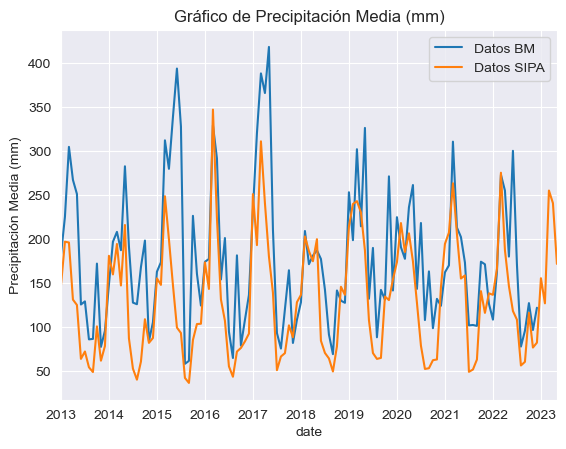

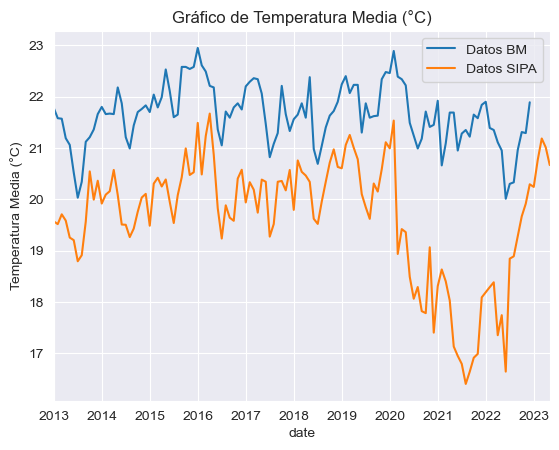

In [35]:
# Revisamos correlaciones entre fuentes de datos distintas:
for col in ('precipitación_media_mm', 'temp_media_Celsius'):
    print(f"Correlación {col}: ", datos_climáticos[col].corr(datos_climáticos_sipa[col][:'2022']))

# Gráfica para precipitación_media_mm
datos_climáticos['precipitación_media_mm'].plot(label='Datos BM')
datos_climáticos_sipa['precipitación_media_mm'].plot(label='Datos SIPA')
plt.legend()
plt.title('Gráfico de Precipitación Media (mm)')
plt.xlabel('date')
plt.ylabel('Precipitación Media (mm)')
plt.show()

# Gráfica para temp_media_Celsius
datos_climáticos['temp_media_Celsius'].plot(label='Datos BM')
datos_climáticos_sipa['temp_media_Celsius'].plot(label='Datos SIPA')
plt.legend()
plt.title('Gráfico de Temperatura Media (°C)')
plt.xlabel('date')
plt.ylabel('Temperatura Media (°C)')
plt.show()


### Importaciones de Insumos Agrícolas

In [36]:
insumos_agrícolas = pd.read_excel('data\importaciones_cif_por_uso.xlsx', sheet_name='insumos_agrícolas')

In [37]:
insumos_agrícolas['date'] = pd.to_datetime(
    insumos_agrícolas['Año'].astype(str) +\
    '-' + \
    insumos_agrícolas['Num Mes'].astype(str)
    ) + pd.offsets.MonthEnd(0)

insumos_agrícolas['Código Matricero'] = insumos_agrícolas['Código Matricero'].astype(str)

insumos_agrícolas = insumos_agrícolas\
    .set_index('date')\
    .drop(columns=['Año', 'Num Mes'])\
    .rename(columns={
        'Valor CIF dólar en miles': 'cif_miles_usd',
        'Matricero': 'matricero_insumos_agrícolas'})\
    [primer_año_análisis:último_año_análisis]
    

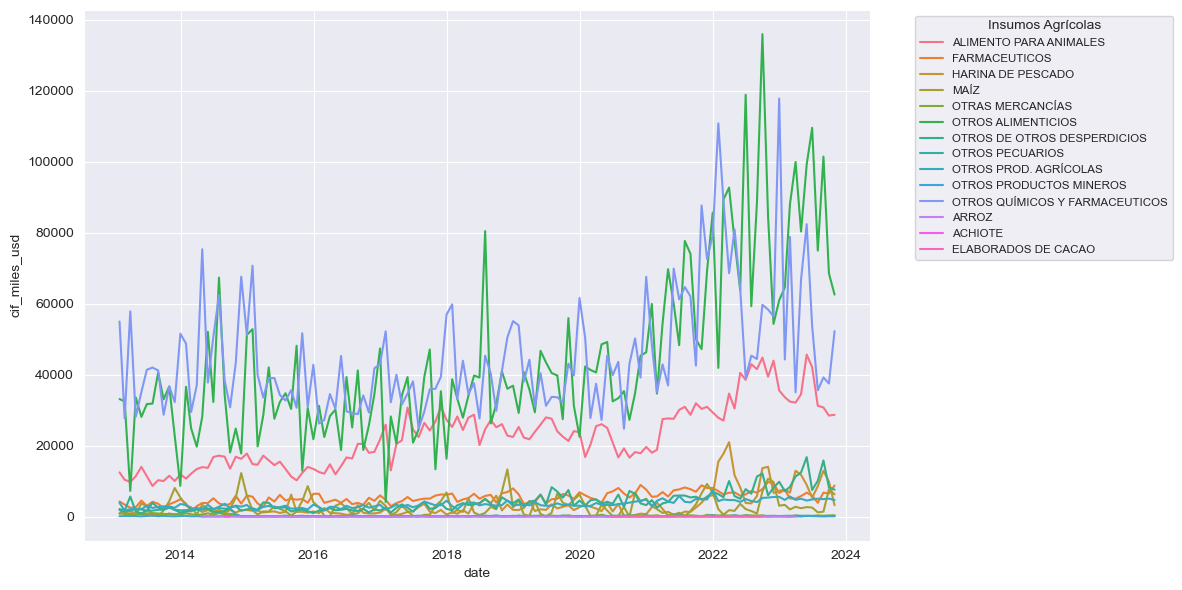

In [38]:
# Crear el gráfico
plt.figure(figsize=(12, 6))
sns.lineplot(x='date', y='cif_miles_usd', data=insumos_agrícolas.reset_index(), hue='matricero_insumos_agrícolas')
plt.legend(title='Insumos Agrícolas', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()

In [39]:
# Crear el DataFrame de insumos como variables, con tabla pivote:
X_insumos = insumos_agrícolas.pivot_table(
    values='cif_miles_usd', 
    index='date', 
    columns='matricero_insumos_agrícolas', 
    aggfunc='sum',
    fill_value=0
    )

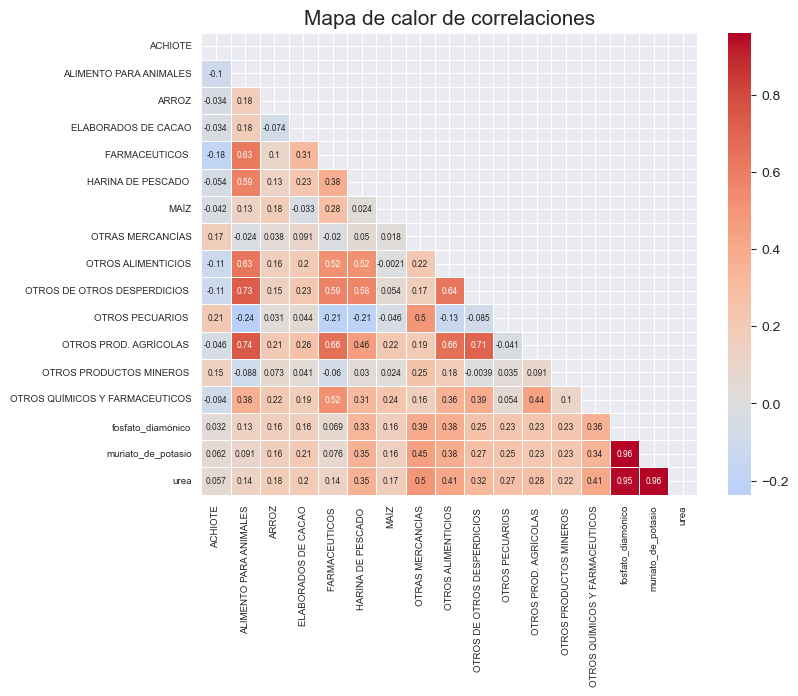

In [40]:
# Unir los DataFrames de insumos y fertilizantes por índice (fechas):
insumos_agrícolas_y_fertilizantes = X_insumos.merge(precios_fertilizantes, left_index=True, right_index=True, how='left')

# Graficar mapa de calor de correlaciones no lineales:
corr = insumos_agrícolas_y_fertilizantes.corr(method="spearman")
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(8, 6))
sns.heatmap(data=corr, mask=mask, cmap='coolwarm', center=0, linewidths=0.5, annot=True, annot_kws={"size": 6})
plt.title('Mapa de calor de correlaciones', size=15)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.show()


In [41]:
import statsmodels.api as sm

# Obtener las variables características regularizadas con una constante:
const_X = sm.add_constant(X_insumos)

target_var = 'urea'

y = insumos_agrícolas_y_fertilizantes[target_var].to_frame()

# Ajustamos una regresión OLS robusta con HC1 para posibles valores atípicos:
model = sm.OLS(y, const_X).fit(cov_type='HC3')
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   urea   R-squared:                       0.740
Model:                            OLS   Adj. R-squared:                  0.709
Method:                 Least Squares   F-statistic:                     17.70
Date:                Fri, 19 Jan 2024   Prob (F-statistic):           1.56e-22
Time:                        15:58:22   Log-Likelihood:                -393.64
No. Observations:                 130   AIC:                             817.3
Df Residuals:                     115   BIC:                             860.3
Df Model:                          14                                         
Covariance Type:                  HC3                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

In [42]:
from sklearn.preprocessing import RobustScaler

# Escalar datos:
X_scaler = RobustScaler()
X_insumos_escalado = X_scaler.fit_transform(X_insumos)

y_scaler = RobustScaler()
y_escalado = y_scaler.fit_transform(y)

# Definir el tamaño del conjunto de entrenamiento
train_size = int(len(X_insumos_escalado) * 0.8)

# Dividir los datos
X_train, X_test = X_insumos_escalado[:train_size], X_insumos_escalado[train_size:]
y_train, y_test = y_escalado[:train_size], y_escalado[train_size:]

In [43]:
from sklearn.linear_model import Lasso, LassoCV
from sklearn.metrics import mean_squared_error

# Definimos una lista de alphas para probar
alphas = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]

# Creamos el modelo LassoCV
lasso_cv = LassoCV(alphas=alphas, cv=5, max_iter=5000)

# Ajustamos el modelo LassoCV a los datos escalados
lasso_cv.fit(X_train, y_train.ravel())

# Obtenemos el alpha óptimo para Lasso
optimal_alpha_lasso = lasso_cv.alpha_
print("Alpha óptimo para Lasso:", optimal_alpha_lasso)

# Ajustar el modelo Lasso con el alpha óptimo
lasso_opt = Lasso(alpha=optimal_alpha_lasso)
lasso_opt.fit(X_insumos_escalado, y_escalado)

# Predecimos con el modelo Lasso:
lasso_predictions = lasso_opt.predict(X_test)
lasso_mse = mean_squared_error(y_test, lasso_predictions)
print("MSE Lasso: ", lasso_mse)


Alpha óptimo para Lasso: 0.001
MSE Lasso:  0.49979840338784354


In [44]:
from sklearn.linear_model import Ridge, RidgeCV

# Creamos el modelo RidgeCV
ridge_cv = RidgeCV(alphas=alphas, cv=5)

# Ajustamos el modelo RidgeCV a los datos escalados
ridge_cv.fit(X_train, y_train)

# Obtenemos el alpha óptimo para Ridge
optimal_alpha_ridge = ridge_cv.alpha_
print("Alpha óptimo para Ridge:", optimal_alpha_ridge)

# Ajustamos el modelo Ridge con el alpha óptimo
ridge_opt = Ridge(alpha=optimal_alpha_ridge)
ridge_opt.fit(X_insumos_escalado, y_escalado)

# Predecimos con el modelo Ridge:
ridge_predictions = ridge_opt.predict(X_test)
ridge_mse = mean_squared_error(y_test, ridge_predictions)
print("MSE Ridge: ", ridge_mse)

Alpha óptimo para Ridge: 10.0
MSE Ridge:  0.5303765688786684


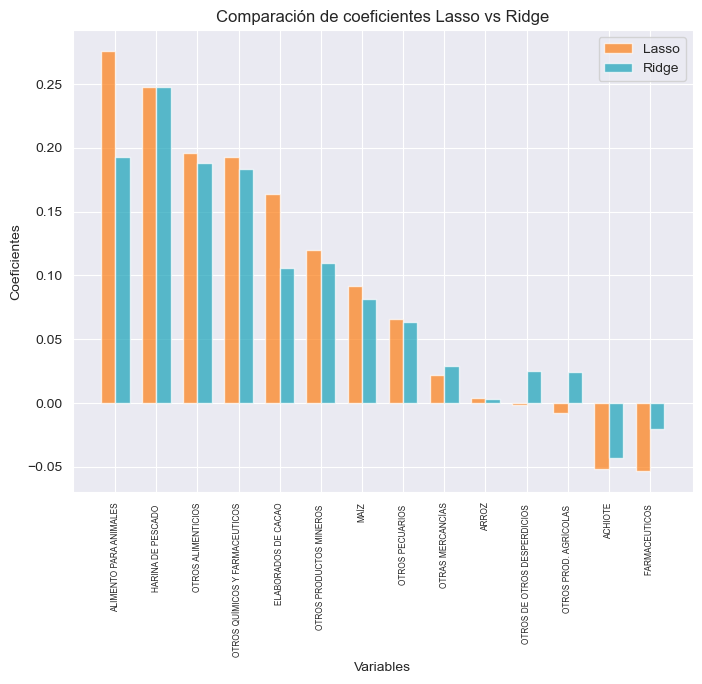

In [45]:
# Creamos un DataFrame con los coeficientes Lasso y Ridge:
regularization_coefs = pd.DataFrame(
    {'X': X_insumos.columns, 
    'lasso_coefs': lasso_opt.coef_.flatten(),
    'ridge_coefs': ridge_opt.coef_.flatten()}
    )

# Ordenamos el DataFrame según los coeficientes de Lasso (o Ridge) en orden descendente:
regularization_coefs = regularization_coefs.sort_values(by=['lasso_coefs', 'ridge_coefs'], ascending=[False, False])

# Creamos un gráfico de barras comparativo:
bar_width = 0.35
index = np.arange(len(regularization_coefs['X']))

fig, ax = plt.subplots(figsize=(8, 6))
bar1 = ax.bar(index, regularization_coefs['lasso_coefs'], bar_width, label='Lasso', color='#fd7e14', alpha=0.7)
bar2 = ax.bar(index + bar_width, regularization_coefs['ridge_coefs'], bar_width, label='Ridge', color='#17a2b8', alpha=0.7)

ax.set_xlabel('Variables')
ax.set_ylabel('Coeficientes')
ax.set_title('Comparación de coeficientes Lasso vs Ridge')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(regularization_coefs['X'], rotation=90, fontsize=6)
ax.legend()
plt.show()

### Exportaciones

In [46]:
exportaciones = pd.read_excel(
    r'data\exportaciones_fob.xlsx',
    sheet_name='Mensual',
    usecols=['Año', 'Num Mes', 'Matricero', 'Valor FOB Dólar en miles']
    )

In [47]:
exportaciones['date'] = pd.to_datetime(
    exportaciones['Año'].astype(str) +\
    '-' + \
    exportaciones['Num Mes'].astype(str)
    ) + pd.offsets.MonthEnd(0)

exportaciones = exportaciones\
    .set_index('date')\
    .drop(columns=['Año', 'Num Mes'])\
    .rename(columns={
        'Valor FOB Dólar en miles': 'fob_miles_usd',
        'Matricero': 'matricero_exportaciones'})\
    [primer_año_análisis:último_año_análisis]

In [48]:
lista_exportaciones_relevantes = sorted(
    ['PRODUCTOS AGRICOLAS EN CONSERVA ', 'OTRAS FIBRAS VEGETALES', 'CARNE, LECHE Y ELABORADOS ', 'PIÑAS ',
    'HOJAS DE TÉ ', 'MELONES ', 'OTROS PROD. AGRÍCOLAS ', 'OTRAS FRUTAS', 'TABACO EN RAMA',
    'OTROS ALIMENTICIOS', 'JUGOS Y CONSERVAS DE FRUTAS ', 'EXTRACTOS Y ACEITES VEGETALES ',
    'ABACÁ ', 'HARINA Y ELABORADOS DE CEREALES ', 'OTROS QUÍMICOS Y FARMACEUTICOS', 'FLORES NATURALES',
    'CAFÉ INDUSTRIALIZADO', 'HARINA DE PESCADO ', 'CAFÉ LAVADO ', 'ELABORADOS DE CACAO ', 'CACAO ',
    'PLÁTANO ', 'ELABORADOS DE BANANO',  'ALIMENTO PARA ANIMALES', 'ALGODÓN ', 'AZÚCAR', 'MAÍZ', 'ARROZ ',
    'MELAZAS Y PANELAS ', 'NARANJAS', 'BANANO', 'CONÍFERAS ', 'ACHIOTE ', 'CAFE NATURAL']
    )

exportaciones_relevantes = exportaciones[exportaciones['matricero_exportaciones'].isin(lista_exportaciones_relevantes)]

In [49]:
# Crear el DataFrame de insumos como variables, con tabla pivote:
X_exportaciones = exportaciones_relevantes.pivot_table(
    values='fob_miles_usd', 
    index='date', 
    columns='matricero_exportaciones', 
    aggfunc='sum',
    fill_value=0
    )

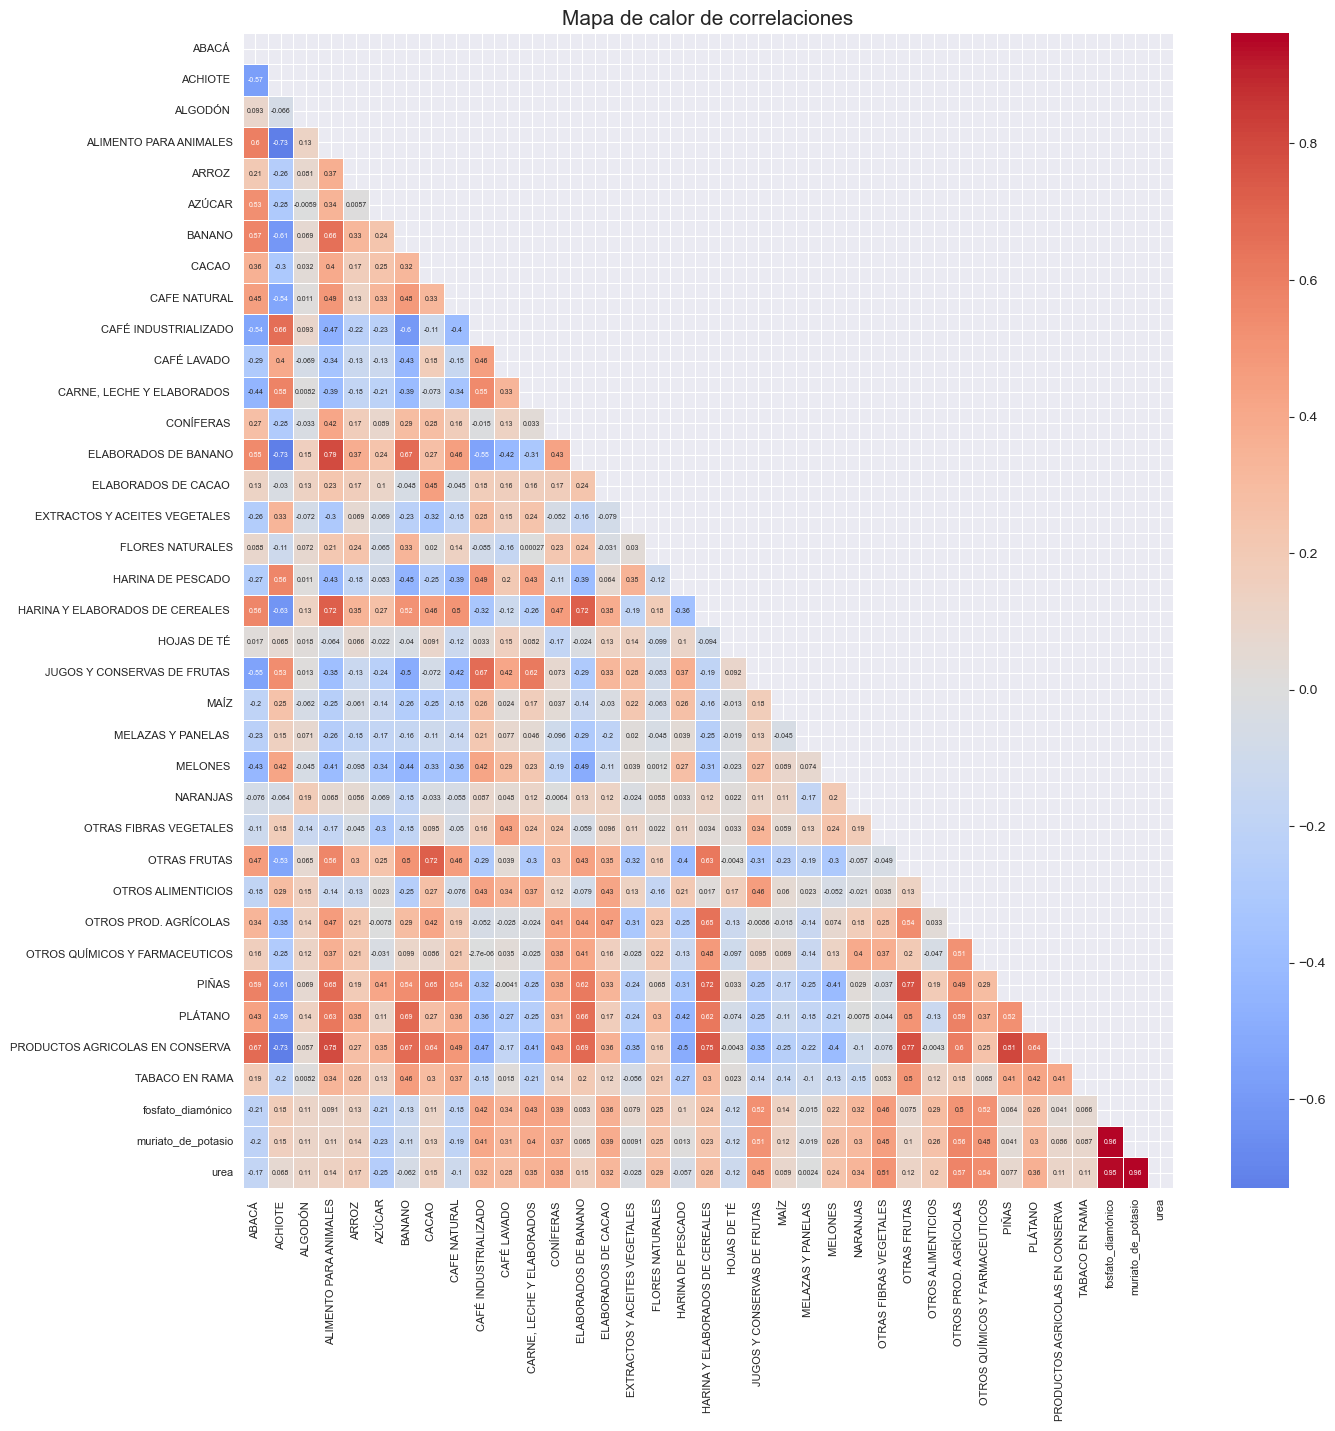

In [50]:
# Unir los DataFrames de insumos y fertilizantes por índice (fechas):
exportaciones_y_fertilizantes = X_exportaciones.merge(precios_fertilizantes, left_index=True, right_index=True, how='left')

# Graficar mapa de calor de correlaciones no lineales:
corr = exportaciones_y_fertilizantes.corr(method="spearman")
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(15, 15))
sns.heatmap(data=corr, mask=mask, cmap='coolwarm', center=0, linewidths=0.5, annot=True, annot_kws={"size": 5})
plt.title('Mapa de calor de correlaciones', size=15)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()

In [51]:
from sklearn.preprocessing import RobustScaler

# Escalar datos:
X_scaler = RobustScaler()
X_exportaciones_escalado = X_scaler.fit_transform(X_exportaciones)

y_scaler = RobustScaler()
y_escalado = y_scaler.fit_transform(y)

# Definir el tamaño del conjunto de entrenamiento
train_size = int(len(X_exportaciones_escalado) * 0.8)

# Dividir los datos
X_train, X_test = X_exportaciones_escalado[:train_size], X_exportaciones_escalado[train_size:]
y_train, y_test = y_escalado[:train_size], y_escalado[train_size:]

In [52]:
from sklearn.linear_model import Lasso, LassoCV
from sklearn.metrics import mean_squared_error

# Definimos una lista de alphas para probar
alphas = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]

# Creamos el modelo LassoCV
lasso_cv = LassoCV(alphas=alphas, cv=5, max_iter=5000)

# Ajustamos el modelo LassoCV a los datos escalados
lasso_cv.fit(X_train, y_train.ravel())

# Obtenemos el alpha óptimo para Lasso
optimal_alpha_lasso = lasso_cv.alpha_
print("Alpha óptimo para Lasso:", optimal_alpha_lasso)

# Ajustar el modelo Lasso con el alpha óptimo
lasso_opt = Lasso(alpha=optimal_alpha_lasso)
lasso_opt.fit(X_exportaciones_escalado, y_escalado)

# Predecimos con el modelo Lasso:
lasso_predictions = lasso_opt.predict(X_test)
lasso_mse = mean_squared_error(y_test, lasso_predictions)
print("MSE Lasso: ", lasso_mse)

Alpha óptimo para Lasso: 0.01
MSE Lasso:  0.2650670718175769


In [53]:
from sklearn.linear_model import Ridge, RidgeCV

# Creamos el modelo RidgeCV
ridge_cv = RidgeCV(alphas=alphas, cv=5)

# Ajustamos el modelo RidgeCV a los datos escalados
ridge_cv.fit(X_train, y_train)

# Obtenemos el alpha óptimo para Ridge
optimal_alpha_ridge = ridge_cv.alpha_
print("Alpha óptimo para Ridge:", optimal_alpha_ridge)

# Ajustamos el modelo Ridge con el alpha óptimo
ridge_opt = Ridge(alpha=optimal_alpha_ridge)
ridge_opt.fit(X_exportaciones_escalado, y_escalado)

# Predecimos con el modelo Ridge:
ridge_predictions = ridge_opt.predict(X_test)
ridge_mse = mean_squared_error(y_test, ridge_predictions)
print("MSE Ridge: ", ridge_mse)

Alpha óptimo para Ridge: 1.0
MSE Ridge:  0.23311052900405543


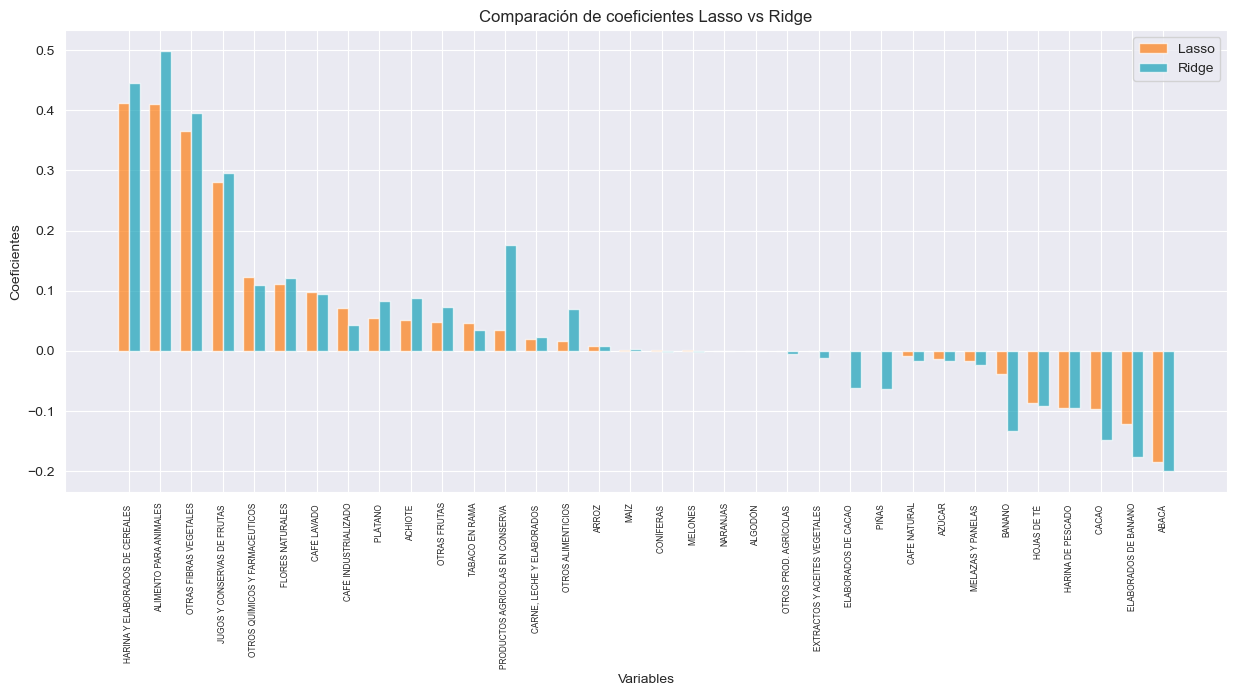

In [54]:
# Creamos un DataFrame con los coeficientes Lasso y Ridge:
regularization_coefs = pd.DataFrame(
    {'X': X_exportaciones.columns, 
    'lasso_coefs': lasso_opt.coef_.flatten(),
    'ridge_coefs': ridge_opt.coef_.flatten()}
    )

# Ordenamos el DataFrame según los coeficientes de Lasso (o Ridge) en orden descendente:
regularization_coefs = regularization_coefs.sort_values(by=['lasso_coefs', 'ridge_coefs'], ascending=[False, False])

# Creamos un gráfico de barras comparativo:
bar_width = 0.35
index = np.arange(len(regularization_coefs['X']))

fig, ax = plt.subplots(figsize=(15, 6))
bar1 = ax.bar(index, regularization_coefs['lasso_coefs'], bar_width, label='Lasso', color='#fd7e14', alpha=0.7)
bar2 = ax.bar(index + bar_width, regularization_coefs['ridge_coefs'], bar_width, label='Ridge', color='#17a2b8', alpha=0.7)

ax.set_xlabel('Variables')
ax.set_ylabel('Coeficientes')
ax.set_title('Comparación de coeficientes Lasso vs Ridge')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(regularization_coefs['X'], rotation=90, fontsize=6)
ax.legend()
plt.show()

### Subsidio urea

Fuente: https://www.agricultura.gob.ec/agricultores-pagaran-el-50-del-costo-comercial-del-saco-de-urea/

In [55]:
index_subsidio = pd.date_range(start='2013-01', end='2024-01', freq='M')

subsidio_urea = pd.DataFrame(index=index_subsidio, columns=['tiene_subsidio_urea'])
subsidio_urea['tiene_subsidio_urea'] = False

# Meses en los que hay subsidio de urea:
meses_con_subsidio = pd.date_range(start='2022-07', end='2024-01', freq='M')

# Marca como True los meses en los que hay subsidio de urea
subsidio_urea.loc[meses_con_subsidio, 'tiene_subsidio_urea'] = True

### Unir DataFrames

In [56]:
frames = [precio_commodities_Europa, inflación_mensual_nacional, precios_combustibles_imp, datos_climáticos_bm_imp, precios_fertilizantes]

for frame in frames:
    print("Rango de fechas:", frame.index.min(), " a ", frame.index.max())

Rango de fechas: 2013-01-31 00:00:00  a  2023-12-31 00:00:00
Rango de fechas: 2013-01-31 00:00:00  a  2023-12-31 00:00:00
Rango de fechas: 2013-01-31 00:00:00  a  2023-12-31 00:00:00
Rango de fechas: 2013-01-31 00:00:00  a  2023-12-31 00:00:00
Rango de fechas: 2013-01-31 00:00:00  a  2023-12-31 00:00:00


In [57]:
# Unir todas las variables en un solo DataFrame:
df = pd.concat(frames, axis=1)

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 132 entries, 2013-01-31 to 2023-12-31
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   precio_crudo_brent_usd_barril  132 non-null    float64
 1   gas_natural_europa_usd_mmbtu   132 non-null    float64
 2   inflación_mensual              132 non-null    float64
 3   diesel                         132 non-null    float64
 4   gasolina_ecológica             132 non-null    float64
 5   gasolina_bajo_octanaje         132 non-null    float64
 6   gasolina_alto_octanaje         132 non-null    float64
 7   precipitación_media_mm         132 non-null    float64
 8   temp_media_Celsius             132 non-null    float64
 9   fosfato_diamónico              132 non-null    float64
 10  muriato_de_potasio             132 non-null    float64
 11  urea                           132 non-null    float64
dtypes: float64(12)
memory usage: 13

### Diferenciación no-estacional y estacional

#### Estacionareidad por *Dickey-Fuller* y *Kwiatkowski-Phillips-Schmidt-Shin*

In [58]:
df_test_estacionareidad = fertilizantes_utils.evaluar_estacionareidad(df)

df_test_estacionareidad

variable  valor_p_adfuller  valor_p_kpss  \
0   precio_crudo_brent_usd_barril      1.179942e-01      0.100000   
1    gas_natural_europa_usd_mmbtu      2.756353e-01      0.031976   
2               inflación_mensual      7.021729e-13      0.079594   
3                          diesel      9.639616e-01      0.010000   
4              gasolina_ecológica      9.290990e-01      0.010000   
5          gasolina_bajo_octanaje      9.185701e-01      0.010000   
6          gasolina_alto_octanaje      9.650531e-01      0.010000   
7          precipitación_media_mm      1.048512e-05      0.100000   
8              temp_media_Celsius      1.654272e-01      0.100000   
9               fosfato_diamónico      3.039583e-01      0.021834   
10             muriato_de_potasio      2.836976e-01      0.017666   
11                           urea      1.907250e-01      0.021808   

    adfuller_rechazar_H0  kpss_rechazar_H0 estado_estacionario  
0                  False             False            No claro  
1                  False              True     No estacionario  
2                   True             False        Estacionario  
3                  False              True     No estacionario  
4                  False              True     No estacionario  
5                  False              True     No estacionario  
6                  False              True     No estacionario  
7                   True             False        Estacionario  
8                  False             False            No claro  
9                  False              True     No estacionario  
10                 False              True     No estacionario  
11                 False              True     No estacionario

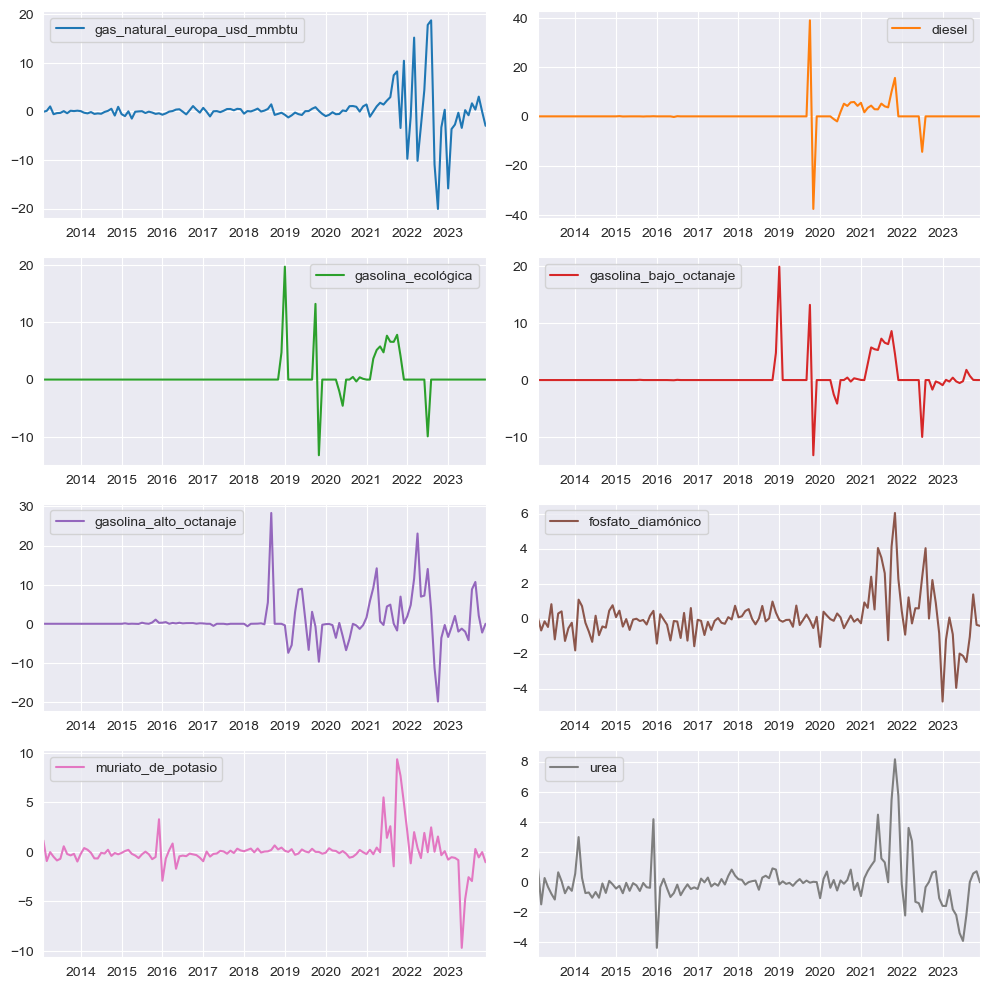

In [60]:
import pmdarima as pm
from pmdarima.arima.utils import ndiffs, nsdiffs

variables_no_estacionarias = df_test_estacionareidad.query("estado_estacionario == 'No estacionario'")['variable'].values

df_no_estacionarias = df[variables_no_estacionarias]

df_diferenciadas = pd.DataFrame(index=pd.date_range(start='2013-02', end='2024-01', freq='M'))

for col in variables_no_estacionarias:
    
    # Determinar el número de diferenciaciones no estacionales
    d = ndiffs(df_no_estacionarias[col])
    
    df_diferenciadas[col] = np.diff(df_no_estacionarias[col], n=d)

df_diferenciadas.plot(
    subplots=True,
    layout=(int(np.ceil(len(variables_no_estacionarias)/2)), 2),
    figsize=(10, 10),
    sharex=False,
    sharey=False
    )
plt.tight_layout()
plt.show()

In [61]:
df_diferenciadas_test = fertilizantes_utils.evaluar_estacionareidad(df_diferenciadas)

df_diferenciadas_test

variable  valor_p_adfuller  valor_p_kpss  \
0  gas_natural_europa_usd_mmbtu      1.462501e-05           0.1   
1                        diesel      5.463813e-28           0.1   
2            gasolina_ecológica      2.083977e-03           0.1   
3        gasolina_bajo_octanaje      2.145208e-03           0.1   
4        gasolina_alto_octanaje      1.538316e-06           0.1   
5             fosfato_diamónico      7.973434e-02           0.1   
6            muriato_de_potasio      5.080163e-05           0.1   
7                          urea      4.891775e-02           0.1   

   adfuller_rechazar_H0  kpss_rechazar_H0 estado_estacionario  
0                  True             False        Estacionario  
1                  True             False        Estacionario  
2                  True             False        Estacionario  
3                  True             False        Estacionario  
4                  True             False        Estacionario  
5                 False             False            No claro  
6                  True             False        Estacionario  
7                  True             False        Estacionario

In [62]:
variables_originalmente_estacionarias = df[
    df_test_estacionareidad\
    .query("estado_estacionario == 'Estacionario'")\
    ['variable']\
    .values
    ]

variables_exitosamente_diferenciadas = df_diferenciadas[
    df_diferenciadas_test\
    .query("estado_estacionario == 'Estacionario'")\
    ['variable']\
    .values
    ]

df_estacionarias = pd.concat(
    [variables_originalmente_estacionarias,
     variables_exitosamente_diferenciadas],
    axis=1)\
    .dropna()
# df_capped = fertilizantes_utils.apply_outlier_capping()

In [74]:
df_estacionarias

inflación_mensual  precipitación_media_mm  \
2013-02-28           0.001847                 224.920   
2013-03-31           0.004384                 304.430   
2013-04-30           0.001790                 266.910   
2013-05-31          -0.002179                 250.850   
2013-06-30          -0.001448                 125.280   
...                       ...                     ...   
2023-08-31           0.005030                  87.512   
2023-09-30           0.000379                 118.649   
2023-10-31          -0.001750                 150.975   
2023-11-30          -0.003992                 130.995   
2023-12-31          -0.000232                 120.856   

            gas_natural_europa_usd_mmbtu  diesel  gasolina_ecológica  \
2013-02-28                     -0.100000     0.0                 0.0   
2013-03-31                      0.100000     0.0                 0.0   
2013-04-30                      1.010000     0.0                 0.0   
2013-05-31                     -0.590000     0.0                 0.0   
2013-06-30                     -0.370000     0.0                 0.0   
...                                  ...     ...                 ...   
2023-08-31                      1.646661     0.0                 0.0   
2023-09-30                      0.357351     0.0                 0.0   
2023-10-31                      3.020212     0.0                 0.0   
2023-11-30                     -0.084452     0.0                 0.0   
2023-12-31                     -2.978397     0.0                 0.0   

            gasolina_bajo_octanaje  gasolina_alto_octanaje  \
2013-02-28                0.000000                0.000000   
2013-03-31                0.000000                0.000000   
2013-04-30                0.000000                0.000000   
2013-05-31                0.000000                0.000000   
2013-06-30                0.000000                0.000000   
...                            ...                     ...   
2023-08-31                1.785299                8.803571   
2023-09-30                0.742004               10.694397   
2023-10-31                0.025813                2.077961   
2023-11-30                0.000000               -2.238623   
2023-12-31                0.000000                0.000000   

            muriato_de_potasio  urea  
2013-02-28                1.15  1.09  
2013-03-31               -0.94 -1.49  
2013-04-30               -0.04  0.26  
2013-05-31               -0.51 -0.33  
2013-06-30               -0.88 -0.79  
...                        ...   ...  
2023-08-31               -2.96 -2.19  
2023-09-30                0.28 -0.01  
2023-10-31               -0.57  0.56  
2023-11-30               -0.04  0.71  
2023-12-31               -1.06 -0.03  

[131 rows x 9 columns]

In [76]:
def apply_outlier_capping(series, multiplier=1.5):
    """
    Aplica capping a los valores atípicos de una serie.

    Parámetros:
    - series (pd.Series): Serie de entrada.
    - multiplier (float): Multiplicador para el IQR para determinar los límites de capping. Default es 1.5.

    Devuelve:
    - pd.Series: Serie con capping aplicado.
    """
    
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1

    # Definir límites
    upper_limit = Q3 + multiplier * IQR
    lower_limit = Q1 - multiplier * IQR

    # Aplicar capping
    series_capped = series.clip(lower=lower_limit, upper=upper_limit)
    
    return pd.Series(series_capped)

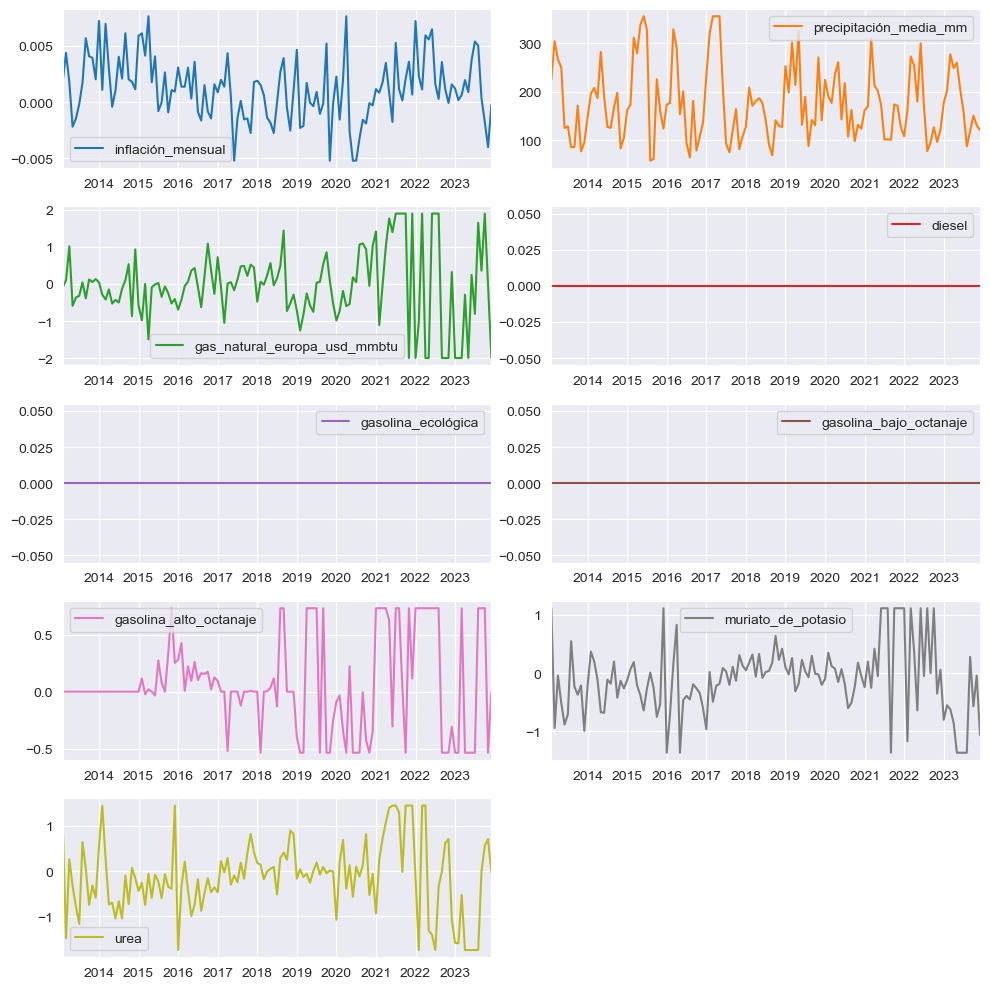

In [79]:

df_capped = pd.DataFrame(index=df_estacionarias.index)

multiplicador = 1.5

for col in df_estacionarias.columns:
    df_capped[col] = apply_outlier_capping(df_estacionarias[col], multiplier=multiplicador)
df_capped.plot(
    subplots=True,
    layout=(int(np.ceil(len(df_capped.columns)/2)), 2),
    figsize=(10, 10),
    sharex=False,
    sharey=False
    )
plt.tight_layout()
plt.show()

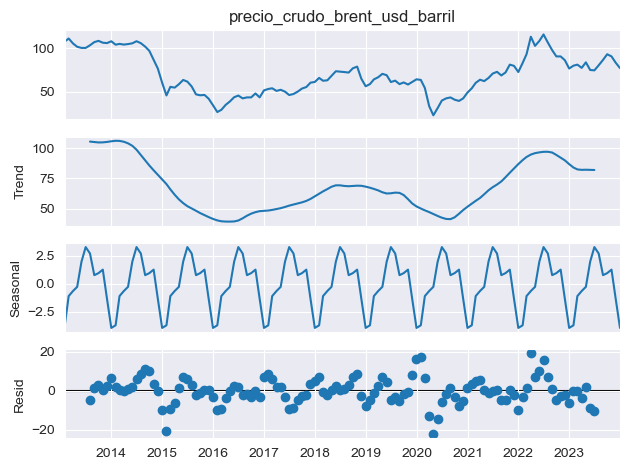

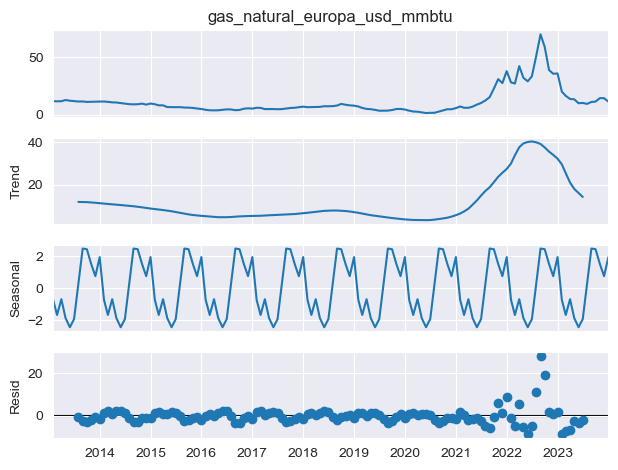

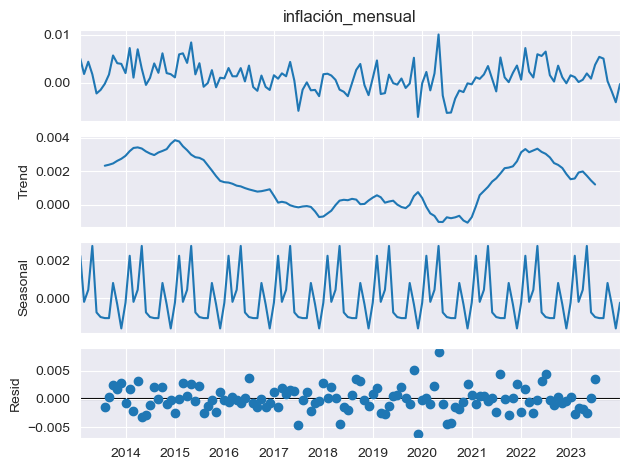

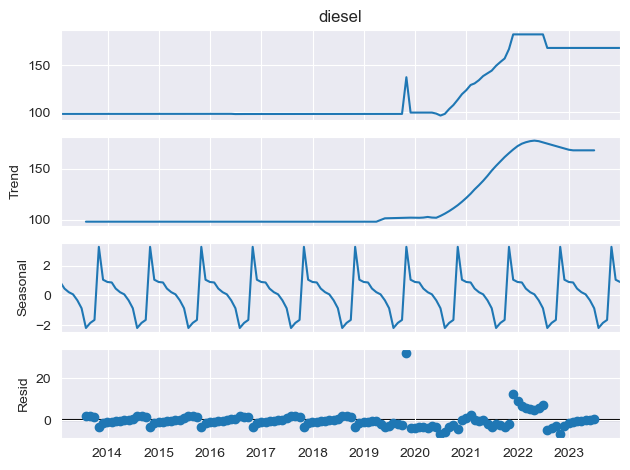

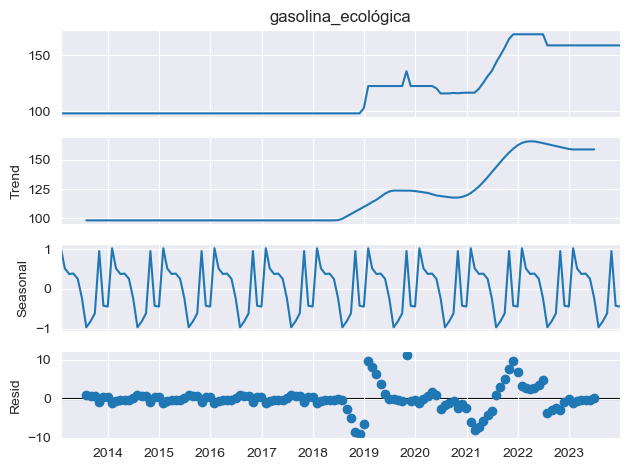

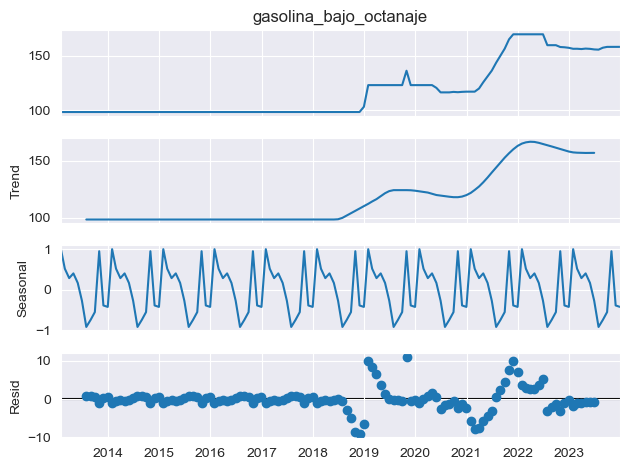

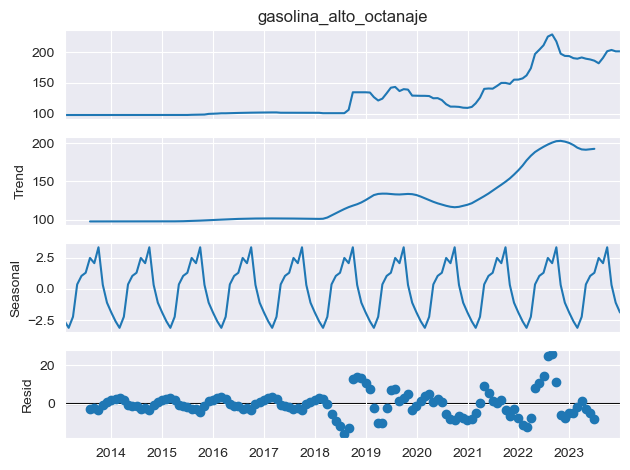

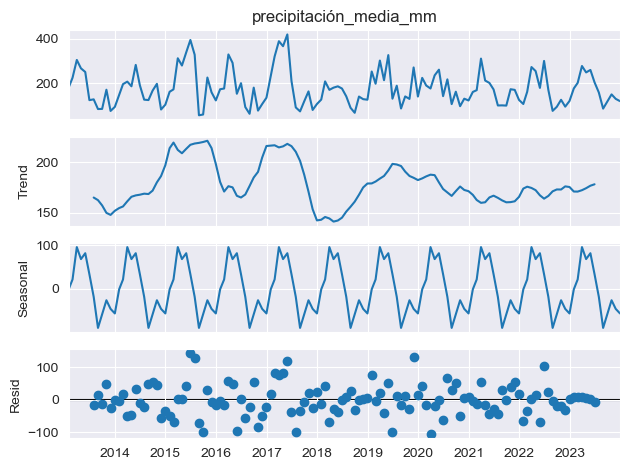

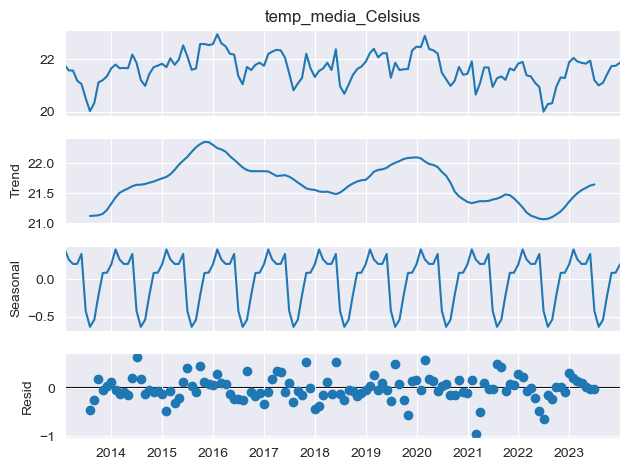

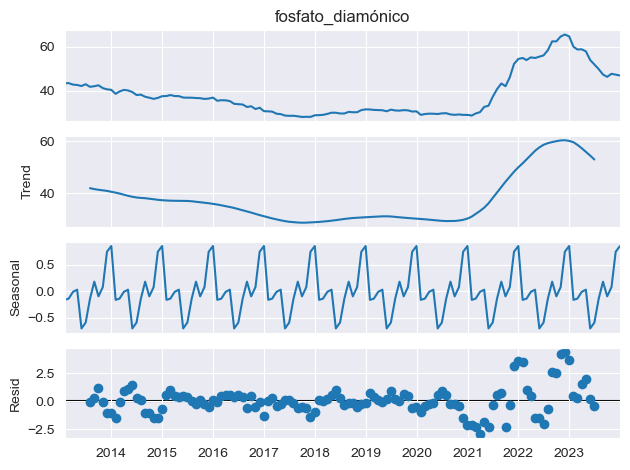

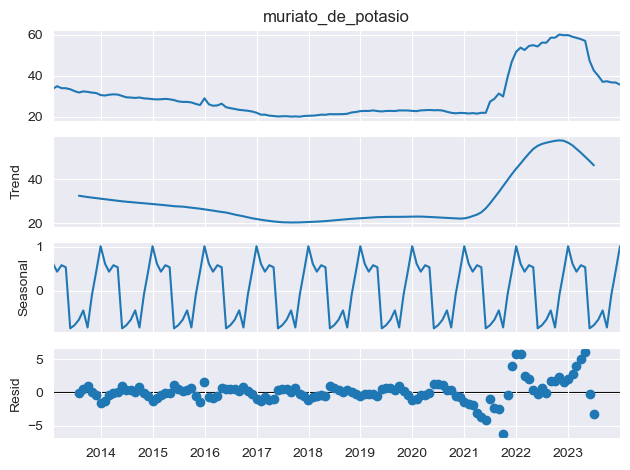

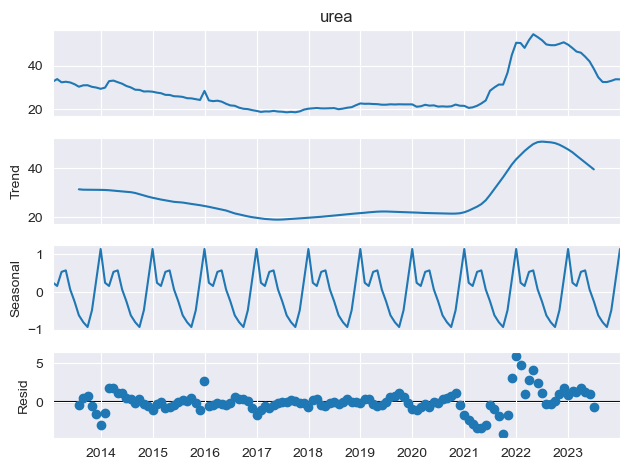

In [64]:
from statsmodels.tsa.seasonal import seasonal_decompose

for col in df.columns:
    decomposition = seasonal_decompose(df[col], model='additive', period=12)
    decomposition.plot()

In [65]:
import pmdarima as pm
from pmdarima.arima.utils import ndiffs, nsdiffs

diffs_dict = {}

for col in df.columns:
    # Determinar el número de diferenciaciones no estacionales
    d = ndiffs(df[col])

    # Determinar el número de diferenciaciones estacionales
    D = nsdiffs(df[col], m=12)
    
    # Almacenar valores de diferenciación:
    diffs_dict[col] = {
        'D' : D,
        'd' : d
        }

diffs_dict

{'precio_crudo_brent_usd_barril': {'D': 0, 'd': 0},
 'gas_natural_europa_usd_mmbtu': {'D': 0, 'd': 1},
 'inflación_mensual': {'D': 0, 'd': 0},
 'diesel': {'D': 0, 'd': 1},
 'gasolina_ecológica': {'D': 0, 'd': 1},
 'gasolina_bajo_octanaje': {'D': 0, 'd': 1},
 'gasolina_alto_octanaje': {'D': 0, 'd': 1},
 'precipitación_media_mm': {'D': 0, 'd': 0},
 'temp_media_Celsius': {'D': 0, 'd': 0},
 'fosfato_diamónico': {'D': 0, 'd': 1},
 'muriato_de_potasio': {'D': 0, 'd': 1},
 'urea': {'D': 0, 'd': 1}}

### Limpieza de series de tiempo

In [66]:
def percent_change(values):
    """
    Calcula el porcentaje de cambio entre el último valor y la media de los valores previos
    """
    previous_values = values[:-1]
    last_value = values[-1]
    pct_change = (last_value - np.mean(previous_values))\
        / np.mean(previous_values)
    return pct_change

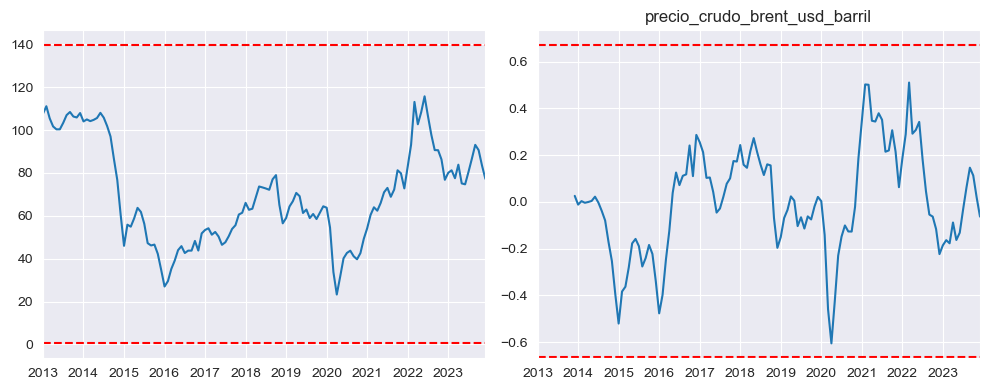

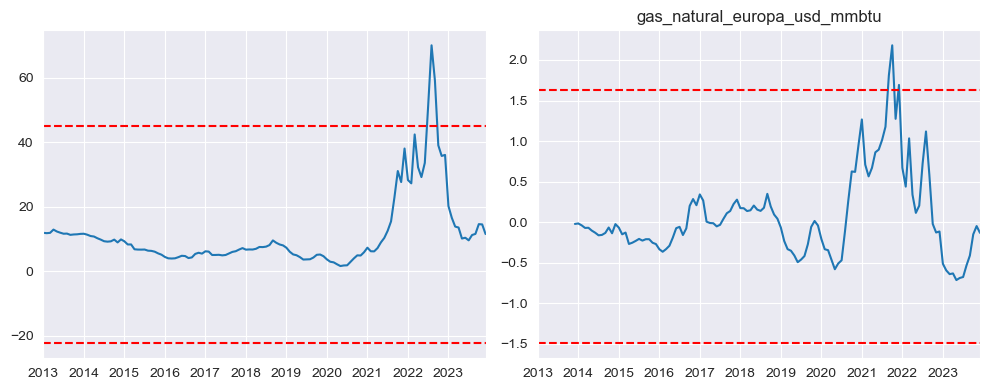

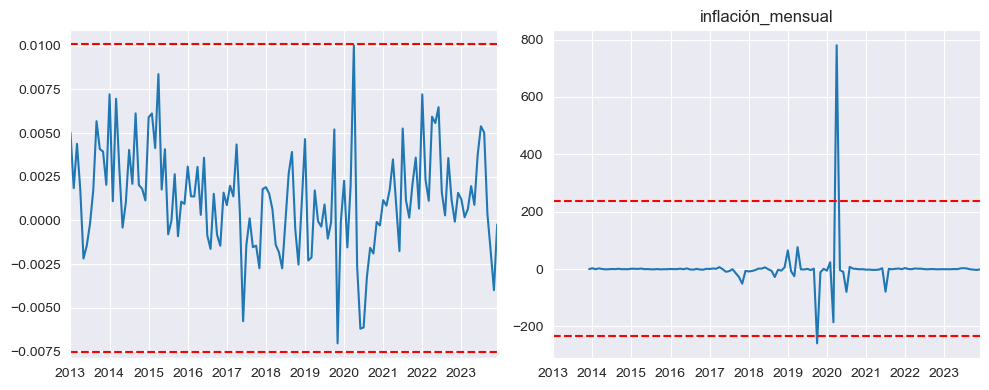

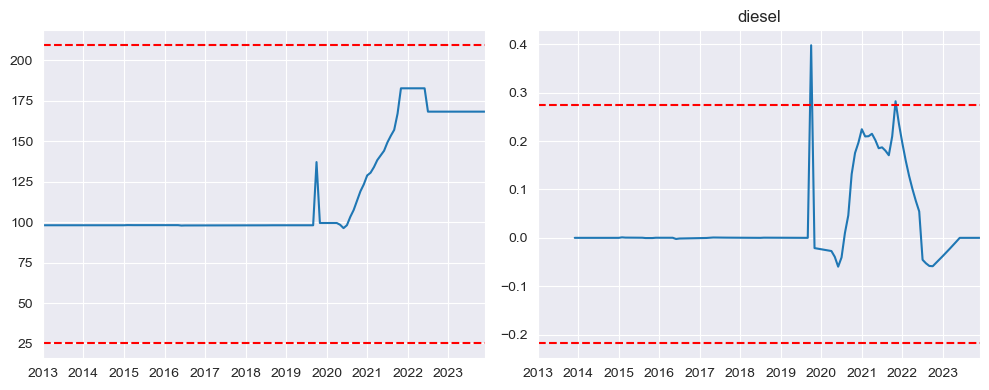

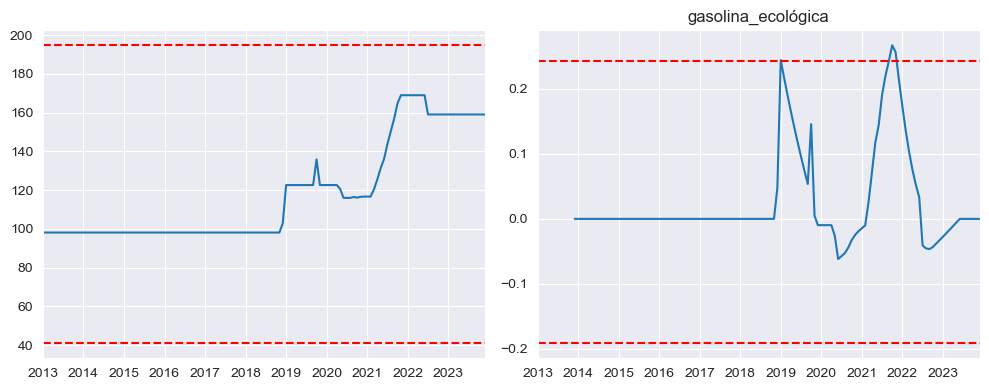

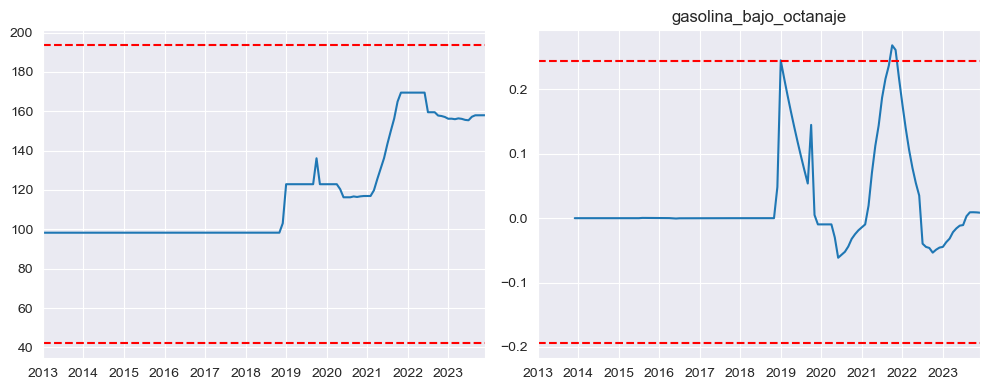

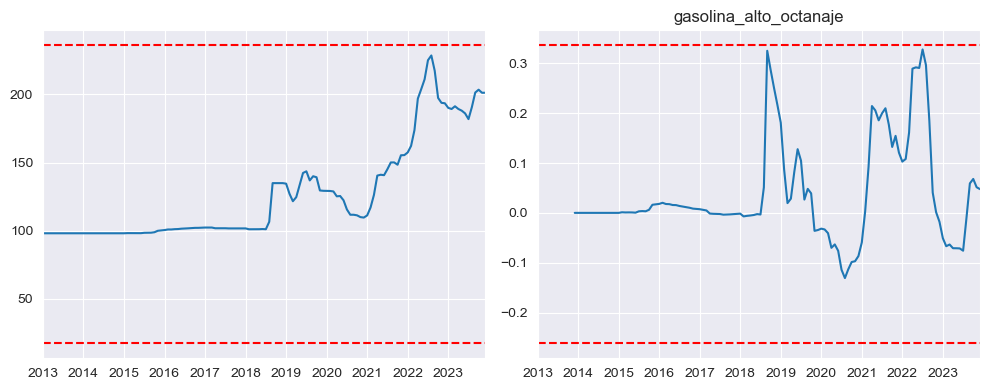

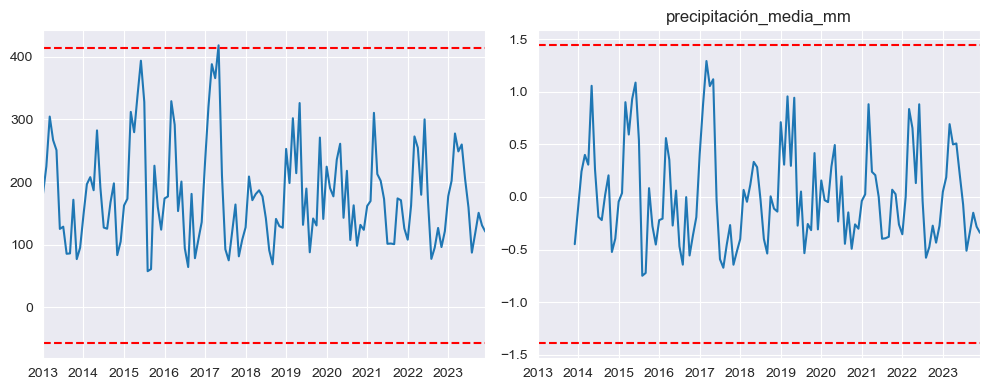

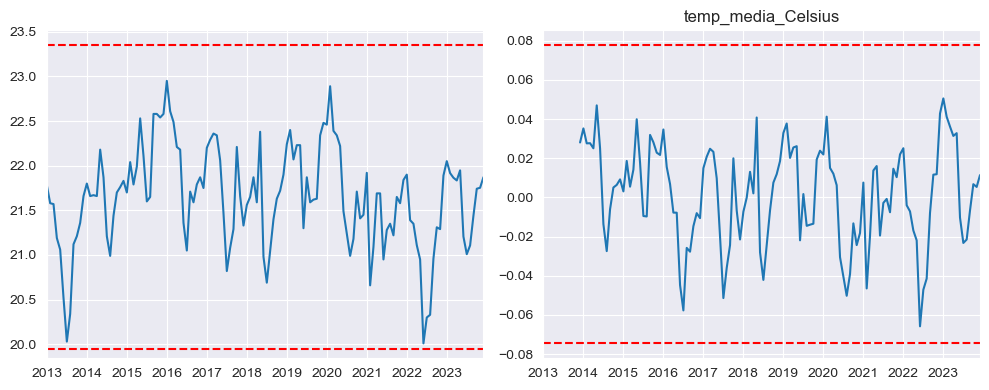

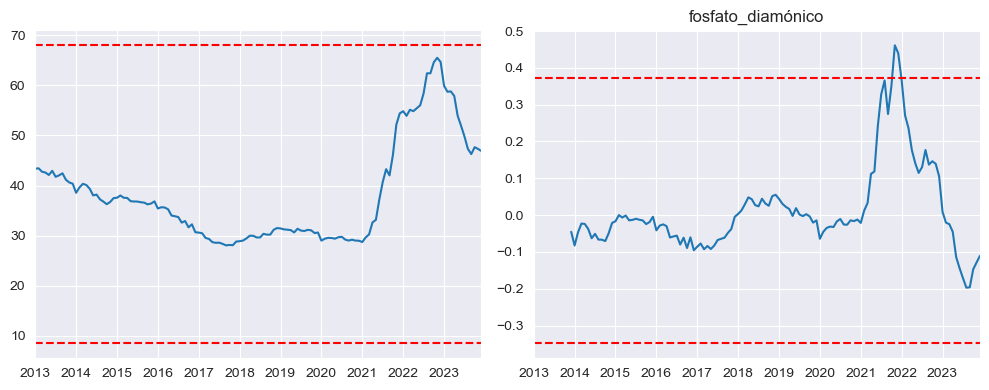

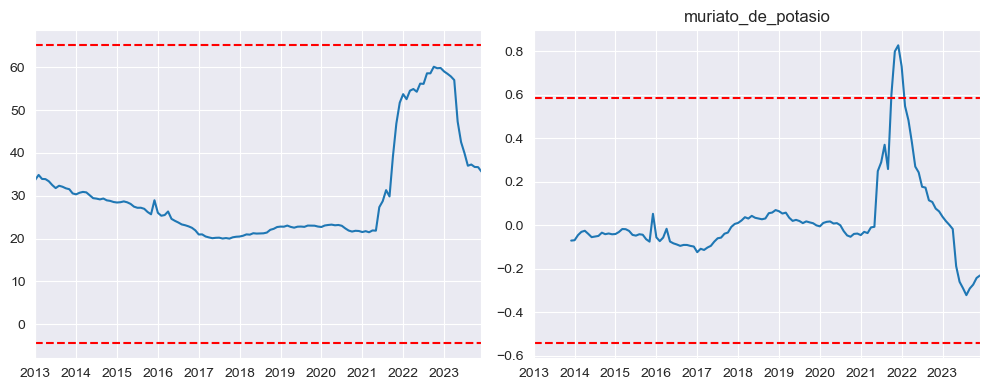

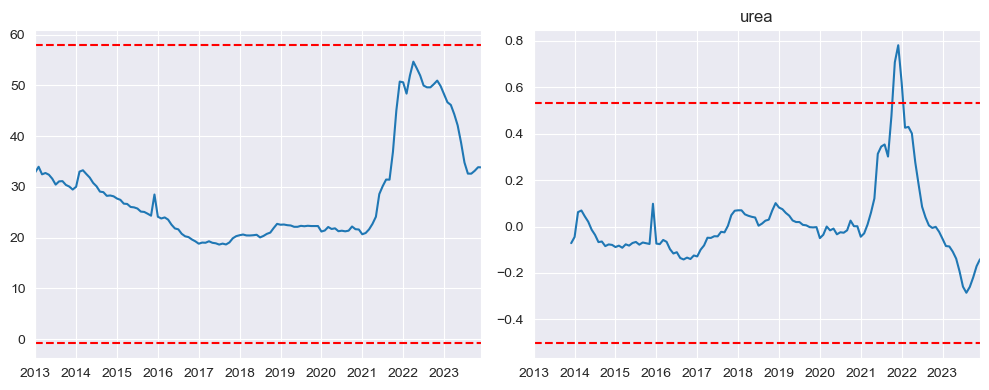

In [67]:
cambio_porcentual_precios = df.copy()

for col in cambio_porcentual_precios.columns:
    cambio_porcentual_precios[col] = cambio_porcentual_precios[col]\
        .rolling(window=12)\
        .aggregate(percent_change)
        
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    
    # Iteramos sobre ambas series de tiempo:
    for data, ax in zip([df[col], cambio_porcentual_precios[col]], axs):
        
        # Calculamos media y desviación estándar:
        mean = data.mean()
        std = data.std()
        
        # Graficamos los datos con un marcador de 3 desviaciones estándar:
        data.plot(ax=ax)
        ax.axhline(mean + std * 3, ls="--", c="r")
        ax.axhline(mean - std * 3, ls="--", c="r")
        
    plt.title(col)
    plt.tight_layout()    
    plt.show()

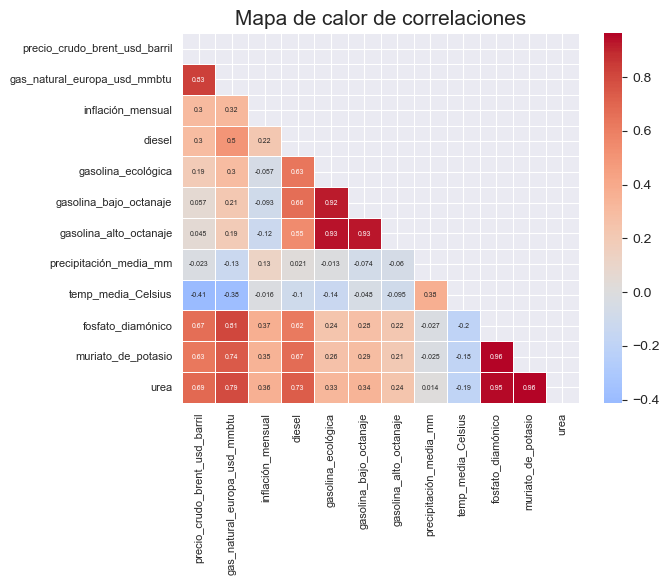

In [68]:
# Graficar mapa de calor de correlaciones no lineales:
corr = df.corr(method="spearman")
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(data=corr, mask=mask, cmap='coolwarm', center=0, linewidths=0.5, annot=True, annot_kws={"size": 5})
plt.title('Mapa de calor de correlaciones', size=15)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()

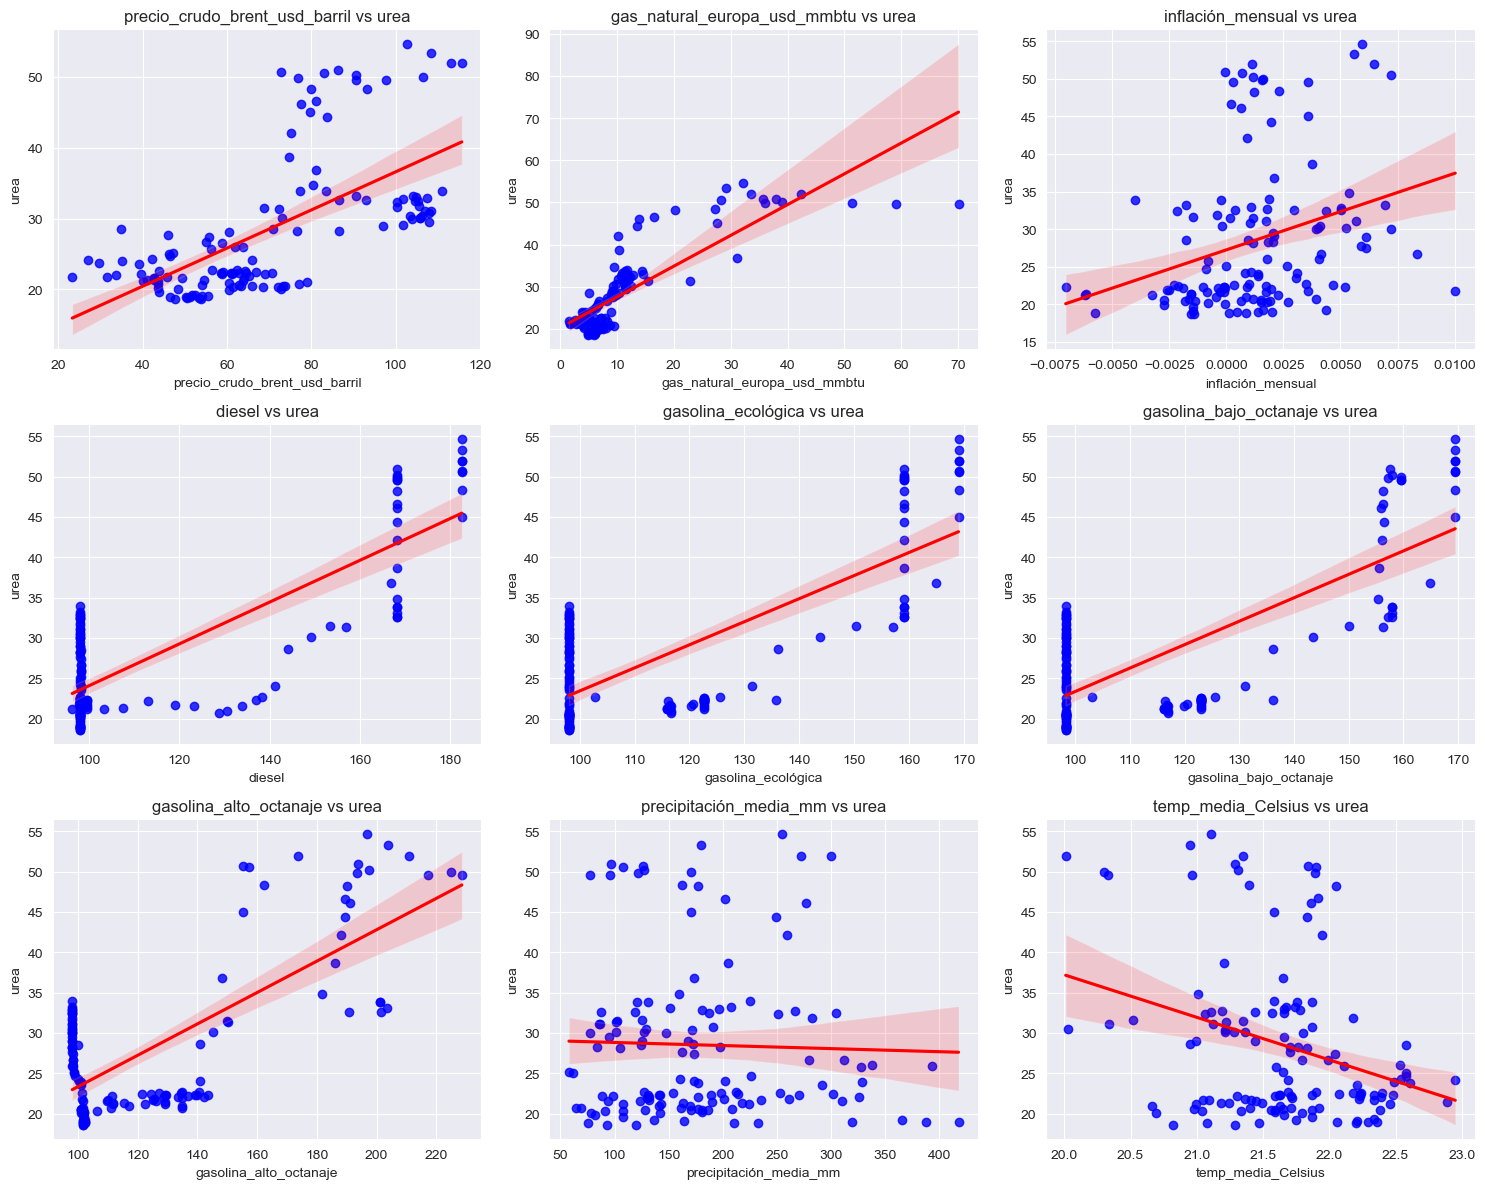

In [69]:
Y_list = ['fosfato_diamónico', 'muriato_de_potasio', 'urea']
target_var= 'urea'

X = df.drop(columns=Y_list)
y = df[target_var]

# Número de características en X
num_features = X.shape[1]

# Determinar el número de filas y columnas para la cuadrícula
num_rows = int(np.ceil(np.sqrt(num_features)))
num_cols = int(np.ceil(num_features / num_rows))

# Crear una cuadrícula de subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(5*num_cols, 4*num_rows))

# Si solo hay una característica, axes no es una lista, así que lo convertimos en una lista para la iteración
if num_features == 1:
    axes = [axes]

# Aplanar la lista de ejes para facilitar la iteración
axes = np.array(axes).flatten()

# Iterar sobre cada característica y crear un diagrama de dispersión con línea de regresión
for i, col in enumerate(X.columns):
    sns.regplot(x=X[col], y=y, ax=axes[i], color='blue', line_kws={"color": "red"})
    
    axes[i].set_title(f'{col} vs {target_var}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel(target_var)

# Eliminar cualquier eje adicional que no se use
for j in range(num_features, num_rows*num_cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

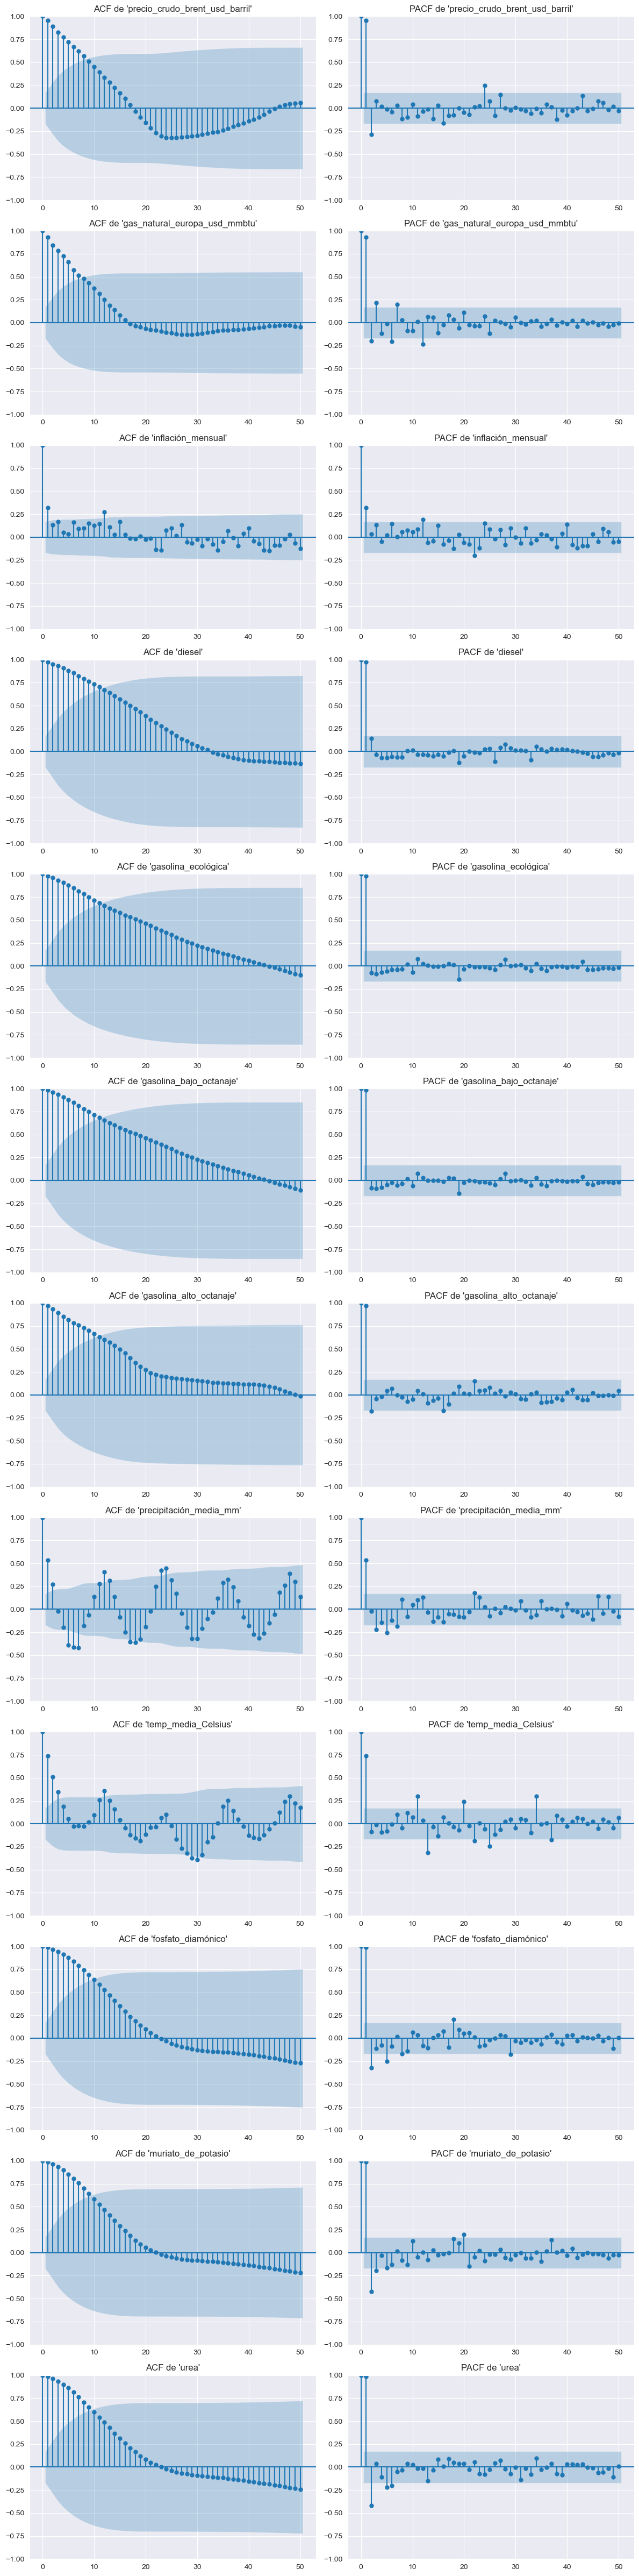

In [70]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Número de variables
n_vars = df.shape[1]

# Creamos una cuadrícula de subgráficos:
fig, axes = plt.subplots(nrows=n_vars, ncols=2, figsize=(12, 4 * n_vars))

for i, column in enumerate(df.columns):
    plot_acf(df[column], lags=50, alpha=0.05, ax=axes[i, 0], title=f"ACF de '{column}'")
    plot_pacf(df[column], lags=50, alpha=0.05, ax=axes[i, 1], title=f"PACF de '{column}'")

plt.tight_layout()
plt.show()

In [71]:
# Obtener las variables características regularizadas con una constante:
const_X = sm.add_constant(X)

# Ajustamos una regresión OLS robusta con HC1 para posibles valores atípicos:
model = sm.OLS(y, const_X).fit(cov_type='HC3')
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   urea   R-squared:                       0.888
Model:                            OLS   Adj. R-squared:                  0.880
Method:                 Least Squares   F-statistic:                     69.74
Date:                Fri, 19 Jan 2024   Prob (F-statistic):           7.46e-44
Time:                        16:04:16   Log-Likelihood:                -343.16
No. Observations:                 132   AIC:                             706.3
Df Residuals:                     122   BIC:                             735.1
Df Model:                           9                                         
Covariance Type:                  HC3                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         